# **Projeto: Quais fatores mais influenciam no desempenho de um aluno no ENEM e como podemos ajudá-lo a melhorar sua performance?**

**Integrantes:** Hellen Cristine Silva Rosa (RA00319076), João Victor Porto (RA00311353), Laura Gabriel Murayama (RA00319321), Maria Eduarda Bonel Iribarnegaray (RA00318891), Vinícius Ferreira de Mendonça (RA00319760), Vitória de Fátima Teixeira (RA00320578)

### **Importando bibliotecas e definindo funções importantes**

In [1]:
SEED = 3

# loading environment variables
from dotenv import load_dotenv
load_dotenv()

# importing sklearn accelerator
from sklearnex import patch_sklearn, unpatch_sklearn

# importing libraries
import os
import re
import psycopg2
import pandas as pd
import numpy as np
import joblib
import skops.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

# importing sklearn functions
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [2]:
# establishing connection with DB
class db_connection():
    '''
    Instantiates a connection with the database.
    '''
    def __init__(self):
        self.DB_URI = os.environ.get('DB_URI')
         
    def __enter__(self):
        self.connection = psycopg2.connect(self.DB_URI)
        return self.connection
    
    def __exit__(self, *args):
        self.connection.close()

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.aggregated_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''
    
    cursor.execute(query)
    aggregated_data = cursor.fetchall()
    aggregated_columns = tuple(desc[0] for desc in cursor.description)


aggregated_df = pd.DataFrame(aggregated_data, columns=aggregated_columns)
aggregated_df

In [3]:
aggregated_df = pd.read_csv('../aggregated_df.csv')
aggregated_df = aggregated_df.replace(np.nan, None)
aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_SG_UF_ESC,PARTICIPANTE_TP_PRESENCA_CN,...,HABESTUDO_Q033B,HABESTUDO_Q033C,HABESTUDO_Q033D,HABESTUDO_Q033E,HABESTUDO_Q033F,HABESTUDO_Q033G,HABESTUDO_Q033H,HABESTUDO_Q033I,HABESTUDO_Q033J,HABESTUDO_Q034
0,210055869019,3,F,1,1,1,1,0,None,1,...,None,None,None,None,None,None,None,None,None,None
1,210055869151,6,F,3,1,5,1,0,None,1,...,None,None,None,None,None,None,None,None,None,None
2,210055870495,4,M,1,2,0,2,0,SP,1,...,None,None,None,None,None,None,None,None,None,None
3,210055871043,3,M,3,1,1,1,0,None,1,...,None,None,None,None,None,None,None,None,None,None
4,210055871271,4,F,1,1,1,1,0,None,1,...,B,B,B,A,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476100,210055867853,3,F,2,2,0,2,0,None,1,...,None,None,None,None,None,None,None,None,None,None
3476101,210055868139,3,F,1,2,0,2,0,SP,1,...,None,None,None,None,None,None,None,None,None,None
3476102,210055868167,3,M,1,2,0,2,0,SP,0,...,None,None,None,None,None,None,None,None,None,None
3476103,210055868291,12,F,3,1,0,1,0,None,0,...,None,None,None,None,None,None,None,None,None,None


### **REQ#01: Utilizar um ou mais datasets para o treinamento dos classificadores**

Utilizaremos os microdados do ENEM 2022, [disponibilizados pelo INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem).

### **REQ#02: Análise Exploratória**

#### Verificando nulos

In [4]:
updated_aggregated_df = aggregated_df.copy()

In [5]:
updated_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_SG_UF_ESC,PARTICIPANTE_TP_PRESENCA_CN,...,HABESTUDO_Q033B,HABESTUDO_Q033C,HABESTUDO_Q033D,HABESTUDO_Q033E,HABESTUDO_Q033F,HABESTUDO_Q033G,HABESTUDO_Q033H,HABESTUDO_Q033I,HABESTUDO_Q033J,HABESTUDO_Q034
0,210055869019,3,F,1,1,1,1,0,None,1,...,None,None,None,None,None,None,None,None,None,None
1,210055869151,6,F,3,1,5,1,0,None,1,...,None,None,None,None,None,None,None,None,None,None
2,210055870495,4,M,1,2,0,2,0,SP,1,...,None,None,None,None,None,None,None,None,None,None
3,210055871043,3,M,3,1,1,1,0,None,1,...,None,None,None,None,None,None,None,None,None,None
4,210055871271,4,F,1,1,1,1,0,None,1,...,B,B,B,A,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476100,210055867853,3,F,2,2,0,2,0,None,1,...,None,None,None,None,None,None,None,None,None,None
3476101,210055868139,3,F,1,2,0,2,0,SP,1,...,None,None,None,None,None,None,None,None,None,None
3476102,210055868167,3,M,1,2,0,2,0,SP,0,...,None,None,None,None,None,None,None,None,None,None
3476103,210055868291,12,F,3,1,0,1,0,None,0,...,None,None,None,None,None,None,None,None,None,None


In [6]:
updated_aggregated_df = updated_aggregated_df.dropna(
    subset=['NU_INSCRICAO', 'PARTICIPANTE_TP_FAIXA_ETARIA', 'PARTICIPANTE_TP_SEXO', 'PARTICIPANTE_TP_COR_RACA', 'PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_TP_ESCOLA', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_SG_UF_ESC', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'PARTICIPANTE_TP_LINGUA', 'PARTICIPANTE_Q005', 'PARTICIPANTE_Q006', 'HABESTUDO_Q001', 'HABESTUDO_Q002', 'HABESTUDO_Q003', 'HABESTUDO_Q004', 'HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q025A', 'HABESTUDO_Q025B', 'HABESTUDO_Q025C', 'HABESTUDO_Q025D', 'HABESTUDO_Q025E', 'HABESTUDO_Q025F', 'HABESTUDO_Q026A', 'HABESTUDO_Q026B', 'HABESTUDO_Q026C', 'HABESTUDO_Q026D', 'HABESTUDO_Q026E', 'HABESTUDO_Q026F', 'HABESTUDO_Q026G', 'HABESTUDO_Q026H', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R', 'HABESTUDO_Q029', 'HABESTUDO_Q030A', 'HABESTUDO_Q030B', 'HABESTUDO_Q030C', 'HABESTUDO_Q030D', 'HABESTUDO_Q030E', 'HABESTUDO_Q030F', 'HABESTUDO_Q030G', 'HABESTUDO_Q031', 'HABESTUDO_Q032A', 'HABESTUDO_Q032B', 'HABESTUDO_Q032C', 'HABESTUDO_Q032D', 'HABESTUDO_Q032E', 'HABESTUDO_Q032F', 'HABESTUDO_Q032G', 'HABESTUDO_Q033A', 'HABESTUDO_Q033B', 'HABESTUDO_Q033C', 'HABESTUDO_Q033D', 'HABESTUDO_Q033E', 'HABESTUDO_Q033F', 'HABESTUDO_Q033G', 'HABESTUDO_Q033H', 'HABESTUDO_Q033I', 'HABESTUDO_Q033J', 'HABESTUDO_Q034']
).reset_index(drop=True)

updated_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_SG_UF_ESC,PARTICIPANTE_TP_PRESENCA_CN,...,HABESTUDO_Q033B,HABESTUDO_Q033C,HABESTUDO_Q033D,HABESTUDO_Q033E,HABESTUDO_Q033F,HABESTUDO_Q033G,HABESTUDO_Q033H,HABESTUDO_Q033I,HABESTUDO_Q033J,HABESTUDO_Q034
0,210055871377,3,F,1,2,0,3,0,PR,1,...,B,B,B,B,A,B,A,B,B,B
1,210055874527,2,F,1,2,0,2,0,SP,1,...,B,A,B,B,A,B,B,B,B,B
2,210055928281,2,F,1,2,0,2,0,SP,1,...,B,B,B,B,B,B,A,B,A,B
3,210055936729,2,M,1,2,0,3,0,SP,1,...,A,B,B,B,B,B,B,B,A,B
4,210055940779,3,M,1,2,0,3,0,SP,1,...,B,B,B,B,B,A,B,B,B,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22947,210055704359,3,F,1,2,0,3,0,RJ,1,...,B,B,B,B,B,B,B,B,A,C
22948,210055736999,3,F,1,2,0,2,0,PE,1,...,A,B,B,B,B,A,B,B,B,A
22949,210055757473,2,F,3,2,0,2,0,MG,1,...,B,A,B,B,B,B,B,B,B,B
22950,210055758151,5,F,3,2,0,2,0,AP,1,...,A,B,B,B,B,B,B,B,B,B


In [7]:
updated_aggregated_df_isna = updated_aggregated_df.isna().sum()
updated_aggregated_df_isna[updated_aggregated_df_isna != 0]

Series([], dtype: int64)

#### Criando novas variáveis

In [8]:
def get_regiao_uf(vetor_uf: pd.Series) -> pd.Series:
    '''
    Informa a região correspondente ao estado a partir de sua sigla.

    :params:
    - vetor_uf: UF do candidato (MICRODADOS_SG_UF_ESC).

    Returns a Series.
    '''

    regioes_list = []

    for uf in vetor_uf:
        regiao_uf_dict = {
            'AM': 'Norte',
            'RR': 'Norte',
            'AP': 'Norte',
            'PA': 'Norte',
            'TO': 'Norte',
            'RO': 'Norte',
            'AC': 'Norte',
            'MA': 'Nordeste',
            'PI': 'Nordeste',
            'CE': 'Nordeste',
            'RN': 'Nordeste',
            'PE': 'Nordeste',
            'PB': 'Nordeste',
            'SE': 'Nordeste',
            'AL': 'Nordeste',
            'BA': 'Nordeste',
            'MT': 'Centro-Oeste',
            'MS': 'Centro-Oeste',
            'GO': 'Centro-Oeste',
            'DF': 'Centro-Oeste',
            'SP': 'Sudeste',
            'RJ': 'Sudeste',
            'ES': 'Sudeste',
            'MG': 'Sudeste',
            'PR': 'Sul',
            'RS': 'Sul',
            'SC': 'Sul',
        }

        regiao = regiao_uf_dict[uf]
        regioes_list.append(regiao)

    return pd.Series(regioes_list)

In [9]:
def get_nota_conceito(vetor_nota_media: pd.Series, porcentagem_quartis: float) -> pd.Series:
    '''
    Converte as notas médias dos participantes em conceitos a partir da divisão dessas notas em quartis.

    :params:
    - vetor_nota_media: nota média do candidato (MICRODADOS_NU_NOTA_MEDIA).
    - porcentagem_quartis: tamanho de cada um dos quartis a ser didivido.

    Returns a Series.
    '''

    quantile_percentages = tuple(map(lambda x: round(x, 2), np.arange(0.0, (1.0 + porcentagem_quartis), porcentagem_quartis)))

    quantiles = tuple(map(lambda x: round(vetor_nota_media.quantile(x), 2), quantile_percentages))

    if quantiles[0] > vetor_nota_media.min():
        quantiles[0] = vetor_nota_media.min()
    if quantiles[-1] < vetor_nota_media.max():
        quantiles[-1] = vetor_nota_media.max()

    quantiles_intervals = tuple(zip(quantiles, quantiles[1:]))


    conceito_list = []

    for nota_media in vetor_nota_media:
        for interval_index, interval in enumerate(quantiles_intervals):
            if (interval[0] <= nota_media) and (nota_media <= interval[1]):
                conceito = interval_index
                conceito_list.append(conceito)
                break


    return pd.Series(conceito_list)

In [10]:
def count_acertos(area_prova: str, vetor_respostas: pd.Series, vetor_gabaritos: pd.Series, vetor_linguas: pd.Series | None = None) -> pd.Series:
    '''
    Conta os acertos de determinada prova.

    :params:
    - area_prova: a qual área corresponde a prova.
    - vetor_respostas: vetor de respostas do candidato.
    - vetor_gabaritos: vetor de gabaritos dada a prova do candidato.
    - vetor_linguas: caso 'area_prova' seja 'LC', a lingua deve ser indicada, sendo 0 para 'inglês' e 1 para 'espanhol'.

    Returns a Series.
    '''

    if (area_prova == 'LC') and (isinstance(vetor_linguas, type(None))):
        raise ValueError('vetor_linguas must be defined for a \'LC\' area_prova.')


    def update_gabarito_with_language(lingua: int, gabarito: str):
        if not isinstance(lingua, int):
            raise ValueError('\'lingua\' is not defined')
        elif lingua == 0:
            updated_gabarito = gabarito[:5] + gabarito[10:]
        elif lingua == 1:
            updated_gabarito = gabarito[5:]
        return updated_gabarito
    

    def check_answers_on_gabarito(acertos_list: list, respostas: str, gabarito: str, lingua: int | None = None):
        if not isinstance(respostas, str):
            acertos_list.append(None)
        else:
            if area_prova == 'LC':
                gabarito = update_gabarito_with_language(lingua, gabarito)

            acertos = 0
            for r, g in zip(respostas, gabarito):
                if r == g:
                    acertos += 1
            acertos_list.append(acertos)
    
    
    acertos_list = []
    if area_prova == 'LC':
        for respostas, gabarito, lingua in zip(vetor_respostas, vetor_gabaritos, vetor_linguas):
            check_answers_on_gabarito(acertos_list, respostas, gabarito, lingua)
    else:
        for respostas, gabarito in zip(vetor_respostas, vetor_gabaritos):
            check_answers_on_gabarito(acertos_list, respostas, gabarito)
    

    return pd.Series(acertos_list)

In [11]:
def get_mediana_renda_per_capita(vetor_renda_total: pd.Series, vetor_tamanho_grupo_familiar: pd.Series) -> pd.Series:
    '''
    Calcula a renda per capita do grupo familiar.

    :params:
    - vetor_renda_total: item de resposta da renda total (MICRODADOS_Q006).
    - vetor_tamanho_grupo_familiar: item de resposta do tamanho do grupo_familiar (MICRODADOS_Q005).

    Returns a Series.
    '''

    renda_per_capita_list = []

    for renda, tamanho_grupo_familiar in zip(vetor_renda_total, vetor_tamanho_grupo_familiar):
        renda_correspondence_dict = {
            'A': (0.00, 0.00),
            'B': (0.00, 1212.00),
            'C': (1212.01, 1818.00),
            'D': (1818.01, 2424.00),
            'E': (2424.01, 3030.00),
            'F': (3030.01, 3636.00),
            'G': (3636.01, 4848.00),
            'H': (4848.01, 6060.00),
            'I': (6060.01, 7272.00),
            'J': (7272.01, 8484.00),
            'K': (8484.01, 9696.00),
            'L': (9696.01, 10908.00),
            'M': (10908.01, 12120.00),
            'N': (12120.01, 14544.00),
            'O': (14544.01, 18180.00),
            'P': (18180.01, 24240.00),
            'Q': (24240.01, float('inf')),
        }
        intervalo_renda = renda_correspondence_dict[renda]

        if intervalo_renda:
            intervalo_renda_per_capita = tuple([amount/tamanho_grupo_familiar for amount in intervalo_renda])
            mediana_renda_per_capita = np.median(intervalo_renda_per_capita)
            mediana_renda_per_capita = round(mediana_renda_per_capita, 2)
            renda_per_capita_list.append(mediana_renda_per_capita)
        else:
            renda_per_capita_list.append(None)

    return pd.Series(renda_per_capita_list)

In [12]:
updated_aggregated_df.loc[:, 'PARTICIPANTE_REGIAO_ESCOLA'] = get_regiao_uf(updated_aggregated_df['PARTICIPANTE_SG_UF_ESC'])

updated_aggregated_df.loc[:, 'NOTAS_NU_NOTA_MEDIA'] = pd.Series(map(lambda x: round(x, 2), (updated_aggregated_df['NOTAS_NU_NOTA_CN'] + updated_aggregated_df['NOTAS_NU_NOTA_CH'] + updated_aggregated_df['NOTAS_NU_NOTA_LC'] + updated_aggregated_df['NOTAS_NU_NOTA_MT'] + updated_aggregated_df['NOTAS_NU_NOTA_REDACAO']) / 5))

updated_aggregated_df.loc[:, 'NOTAS_NU_NOTA_CONCEITO'] = get_nota_conceito(updated_aggregated_df['NOTAS_NU_NOTA_MEDIA'], 0.25)

updated_aggregated_df.loc[:, 'NOTAS_NU_ACERTOS_CN'] = count_acertos('CN', updated_aggregated_df['NOTAS_TX_RESPOSTAS_CN'], updated_aggregated_df['NOTAS_TX_GABARITO_CN'])
updated_aggregated_df.loc[:, 'NOTAS_NU_ACERTOS_CH'] = count_acertos('CH', updated_aggregated_df['NOTAS_TX_RESPOSTAS_CH'], updated_aggregated_df['NOTAS_TX_GABARITO_CH'])
updated_aggregated_df.loc[:, 'NOTAS_NU_ACERTOS_LC'] = count_acertos('LC', updated_aggregated_df['NOTAS_TX_RESPOSTAS_LC'], updated_aggregated_df['NOTAS_TX_GABARITO_LC'], updated_aggregated_df['PARTICIPANTE_TP_LINGUA'])
updated_aggregated_df.loc[:, 'NOTAS_NU_ACERTOS_MT'] = count_acertos('MT', updated_aggregated_df['NOTAS_TX_RESPOSTAS_MT'], updated_aggregated_df['NOTAS_TX_GABARITO_MT'])

updated_aggregated_df.loc[:, 'NOTAS_NU_ACERTOS_TOTAL'] = updated_aggregated_df['NOTAS_NU_ACERTOS_CN'] + updated_aggregated_df['NOTAS_NU_ACERTOS_CH'] + updated_aggregated_df['NOTAS_NU_ACERTOS_LC'] + updated_aggregated_df['NOTAS_NU_ACERTOS_MT']
updated_aggregated_df.loc[:, 'NOTAS_NU_ACERTOS_MEDIO'] = round(updated_aggregated_df['NOTAS_NU_ACERTOS_TOTAL'] / 4, 2)

updated_aggregated_df.loc[:, 'PARTICIPANTE_RENDA_PER_CAPITA'] = get_mediana_renda_per_capita(updated_aggregated_df['PARTICIPANTE_Q006'], updated_aggregated_df['PARTICIPANTE_Q005'])


updated_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_SG_UF_ESC,PARTICIPANTE_TP_PRESENCA_CN,...,PARTICIPANTE_REGIAO_ESCOLA,NOTAS_NU_NOTA_MEDIA,NOTAS_NU_NOTA_CONCEITO,NOTAS_NU_ACERTOS_CN,NOTAS_NU_ACERTOS_CH,NOTAS_NU_ACERTOS_LC,NOTAS_NU_ACERTOS_MT,NOTAS_NU_ACERTOS_TOTAL,NOTAS_NU_ACERTOS_MEDIO,PARTICIPANTE_RENDA_PER_CAPITA
0,210055871377,3,F,1,2,0,3,0,PR,1,...,Sul,457.02,0,5,11,15,8,39,9.75,inf
1,210055874527,2,F,1,2,0,2,0,SP,1,...,Sudeste,486.92,1,12,8,17,15,52,13.00,1363.50
2,210055928281,2,F,1,2,0,2,0,SP,1,...,Sudeste,598.80,3,16,16,20,17,69,17.25,1060.50
3,210055936729,2,M,1,2,0,3,0,SP,1,...,Sudeste,536.06,2,9,17,13,18,57,14.25,681.75
4,210055940779,3,M,1,2,0,3,0,SP,1,...,Sudeste,544.16,2,15,23,23,7,68,17.00,1363.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22947,210055704359,3,F,1,2,0,3,0,RJ,1,...,Sudeste,652.74,3,12,25,26,16,79,19.75,303.00
22948,210055736999,3,F,1,2,0,2,0,PE,1,...,Nordeste,515.34,2,6,11,24,10,51,12.75,202.00
22949,210055757473,2,F,3,2,0,2,0,MG,1,...,Sudeste,499.60,1,14,13,16,13,56,14.00,545.40
22950,210055758151,5,F,3,2,0,2,0,AP,1,...,Norte,414.04,0,12,20,18,10,60,15.00,0.00


In [13]:
def get_hab_estudo_category_values(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Une as colunas de respostas dos hábitos de estudo por categoria, normalizando as respostas.

    :params:
    - df: DataFrame com todos os dados para substituição.

    Returns a DataFrame.
    '''

    # colocar variáveis em ordem crescente de dificuldade/falta de estudo (positividade)
    # em caso de sim/não, utilizar 'sim' como maior
    hab_estudo_correspondence_dict = {
        'HABESTUDO_ST_MAT_PERC_APR': {
            'HABESTUDO_Q001': ('E', 'D', 'C', 'B', 'A'),
            'HABESTUDO_Q002': ('C', 'B', 'A'),
            'HABESTUDO_Q003': ('E', 'D', 'C', 'B', 'A'),
            'HABESTUDO_Q004': ('F', 'E', 'D', 'C', 'B', 'A'),
            },
        'HABESTUDO_GES_TEMP_PLAN_EST': {
            'HABESTUDO_Q005': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q006': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q007': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q008': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q021': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q022': ('A', 'B', 'C', 'D'),
            },
        'HABESTUDO_PRAT_EST_PES': {
            'HABESTUDO_Q009': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q010': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q011': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q012': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q013': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q014': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q015': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q016': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q017': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q018': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q019': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q020': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q023': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q024': ('A', 'B', 'C', 'D'),
            },
        'HABESTUDO_TECN_TP_ACES': {
            'HABESTUDO_Q025A': ('B', 'A'),
            'HABESTUDO_Q025B': ('B', 'A'),
            'HABESTUDO_Q025C': ('B', 'A'),
            'HABESTUDO_Q025D': ('B', 'A'),
            'HABESTUDO_Q025E': ('B', 'A'),
            'HABESTUDO_Q025F': ('B', 'A'),
            'HABESTUDO_Q026A': ('B', 'A'),
            'HABESTUDO_Q026B': ('B', 'A'),
            'HABESTUDO_Q026C': ('B', 'A'),
            'HABESTUDO_Q026D': ('B', 'A'),
            'HABESTUDO_Q026E': ('B', 'A'),
            'HABESTUDO_Q026F': ('B', 'A'),
            'HABESTUDO_Q026G': ('B', 'A'),
            'HABESTUDO_Q026H': ('B', 'A'),
            },
        'HABESTUDO_PROB_ROT_EST': {
            'HABESTUDO_Q027': ('B', 'A'),
            'HABESTUDO_Q028A': ('B', 'A'),
            'HABESTUDO_Q028B': ('B', 'A'),
            'HABESTUDO_Q028C': ('B', 'A'),
            'HABESTUDO_Q028D': ('B', 'A'),
            'HABESTUDO_Q028E': ('B', 'A'),
            'HABESTUDO_Q028F': ('B', 'A'),
            'HABESTUDO_Q028G': ('B', 'A'),
            'HABESTUDO_Q028H': ('B', 'A'),
            'HABESTUDO_Q028I': ('B', 'A'),
            'HABESTUDO_Q028J': ('B', 'A'),
            'HABESTUDO_Q028K': ('B', 'A'),
            'HABESTUDO_Q028L': ('B', 'A'),
            'HABESTUDO_Q028M': ('B', 'A'),
            'HABESTUDO_Q028N': ('B', 'A'),
            'HABESTUDO_Q028O': ('B', 'A'),
            'HABESTUDO_Q028P': ('B', 'A'),
            'HABESTUDO_Q028Q': ('B', 'A'),
            'HABESTUDO_Q028R': ('B', 'A'),
            },
        'HABESTUDO_DIF_INFR': {
            'HABESTUDO_Q029': ('B', 'A'),
            'HABESTUDO_Q030A': ('B', 'A'),
            'HABESTUDO_Q030B': ('B', 'A'),
            'HABESTUDO_Q030C': ('B', 'A'),
            'HABESTUDO_Q030D': ('B', 'A'),
            'HABESTUDO_Q030E': ('B', 'A'),
            'HABESTUDO_Q030F': ('B', 'A'),
            'HABESTUDO_Q030G': ('B', 'A'),
            },
        'HABESTUDO_AJUD_TERC': {
            'HABESTUDO_Q031': ('C', 'A', 'B'),
            'HABESTUDO_Q032A': ('B', 'A'),
            'HABESTUDO_Q032B': ('B', 'A'),
            'HABESTUDO_Q032C': ('B', 'A'),
            'HABESTUDO_Q032D': ('B', 'A'),
            'HABESTUDO_Q032E': ('B', 'A'),
            'HABESTUDO_Q032F': ('B', 'A'),
            'HABESTUDO_Q032G': ('B', 'A'),
            'HABESTUDO_Q033A': ('B', 'A'),
            'HABESTUDO_Q033B': ('B', 'A'),
            'HABESTUDO_Q033C': ('B', 'A'),
            'HABESTUDO_Q033D': ('B', 'A'),
            'HABESTUDO_Q033E': ('B', 'A'),
            'HABESTUDO_Q033F': ('B', 'A'),
            'HABESTUDO_Q033G': ('B', 'A'),
            'HABESTUDO_Q033H': ('B', 'A'),
            'HABESTUDO_Q033I': ('B', 'A'),
            'HABESTUDO_Q033J': ('B', 'A'),
            },
        'HABESTUDO_AVAL_PROP_EXP': {
            'HABESTUDO_Q034': ('A', 'B', 'C', 'D', 'E'),
            },
    }


    for column_name, column_questions_dict in hab_estudo_correspondence_dict.items():
        column_series_dict = {}

        for question_name, question_value_list in column_questions_dict.items():
            question_series = []
            
            for student_answer in df[question_name]:
                row_value = question_value_list.index(student_answer) / (len(question_value_list) - 1)
                row_value = round(row_value, 2)
                question_series.append(row_value)
            
            column_series_dict[question_name] = question_series

        column_series = pd.Series(zip(*column_series_dict.values()))
        column_series = column_series.apply(lambda values_tuple: sum(values_tuple))

        df.loc[:, column_name] = column_series


    return df

In [14]:
updated_aggregated_df = get_hab_estudo_category_values(updated_aggregated_df)
updated_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_SG_UF_ESC,PARTICIPANTE_TP_PRESENCA_CN,...,NOTAS_NU_ACERTOS_MEDIO,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210055871377,3,F,1,2,0,3,0,PR,1,...,9.75,inf,3.60,3.00,7.34,2.0,5.0,2.0,3.5,0.25
1,210055874527,2,F,1,2,0,2,0,SP,1,...,13.00,1363.50,3.30,3.32,8.36,4.0,7.0,3.0,4.5,0.25
2,210055928281,2,F,1,2,0,2,0,SP,1,...,17.25,1060.50,3.10,2.32,4.96,4.0,2.0,1.0,4.5,0.25
3,210055936729,2,M,1,2,0,3,0,SP,1,...,14.25,681.75,3.10,2.99,5.64,2.0,2.0,3.0,3.5,0.25
4,210055940779,3,M,1,2,0,3,0,SP,1,...,17.00,1363.50,2.60,2.66,4.29,2.0,7.0,2.0,2.5,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22947,210055704359,3,F,1,2,0,3,0,RJ,1,...,19.75,303.00,2.60,5.34,11.68,4.0,11.0,3.0,2.5,0.50
22948,210055736999,3,F,1,2,0,2,0,PE,1,...,12.75,202.00,3.10,3.00,8.70,3.0,2.0,3.0,3.5,0.00
22949,210055757473,2,F,3,2,0,2,0,MG,1,...,14.00,545.40,3.35,1.66,3.98,2.0,3.0,2.0,3.5,0.25
22950,210055758151,5,F,3,2,0,2,0,AP,1,...,15.00,0.00,1.85,1.65,2.65,3.0,3.0,3.0,3.5,0.25


#### Filtrando variáveis

In [15]:
interest_variables = ['NU_INSCRICAO', 'PARTICIPANTE_TP_FAIXA_ETARIA', 'PARTICIPANTE_TP_SEXO', 'PARTICIPANTE_TP_COR_RACA', 'PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_TP_ESCOLA', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_REGIAO_ESCOLA', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO', 'NOTAS_NU_ACERTOS_CN', 'NOTAS_NU_ACERTOS_CH', 'NOTAS_NU_ACERTOS_LC', 'NOTAS_NU_ACERTOS_MT', 'NOTAS_NU_ACERTOS_TOTAL', 'NOTAS_NU_ACERTOS_MEDIO', 'PARTICIPANTE_TP_LINGUA', 'PARTICIPANTE_RENDA_PER_CAPITA', 'HABESTUDO_ST_MAT_PERC_APR', 'HABESTUDO_GES_TEMP_PLAN_EST', 'HABESTUDO_PRAT_EST_PES', 'HABESTUDO_TECN_TP_ACES', 'HABESTUDO_PROB_ROT_EST', 'HABESTUDO_DIF_INFR', 'HABESTUDO_AJUD_TERC', 'HABESTUDO_AVAL_PROP_EXP']

filtered_aggregated_df = updated_aggregated_df.loc[:, interest_variables]
filtered_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_REGIAO_ESCOLA,PARTICIPANTE_TP_PRESENCA_CN,...,PARTICIPANTE_TP_LINGUA,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210055871377,3,F,1,2,0,3,0,Sul,1,...,0,inf,3.60,3.00,7.34,2.0,5.0,2.0,3.5,0.25
1,210055874527,2,F,1,2,0,2,0,Sudeste,1,...,0,1363.50,3.30,3.32,8.36,4.0,7.0,3.0,4.5,0.25
2,210055928281,2,F,1,2,0,2,0,Sudeste,1,...,0,1060.50,3.10,2.32,4.96,4.0,2.0,1.0,4.5,0.25
3,210055936729,2,M,1,2,0,3,0,Sudeste,1,...,1,681.75,3.10,2.99,5.64,2.0,2.0,3.0,3.5,0.25
4,210055940779,3,M,1,2,0,3,0,Sudeste,1,...,0,1363.50,2.60,2.66,4.29,2.0,7.0,2.0,2.5,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22947,210055704359,3,F,1,2,0,3,0,Sudeste,1,...,0,303.00,2.60,5.34,11.68,4.0,11.0,3.0,2.5,0.50
22948,210055736999,3,F,1,2,0,2,0,Nordeste,1,...,0,202.00,3.10,3.00,8.70,3.0,2.0,3.0,3.5,0.00
22949,210055757473,2,F,3,2,0,2,0,Sudeste,1,...,1,545.40,3.35,1.66,3.98,2.0,3.0,2.0,3.5,0.25
22950,210055758151,5,F,3,2,0,2,0,Norte,1,...,1,0.00,1.85,1.65,2.65,3.0,3.0,3.0,3.5,0.25


#### Excluindo rendas per capita infinitas

In [16]:
renda_inf_indexes = filtered_aggregated_df[filtered_aggregated_df['PARTICIPANTE_RENDA_PER_CAPITA'] == float('inf')].index

filtered_aggregated_df = filtered_aggregated_df.drop(index=renda_inf_indexes).reset_index(drop=True)
filtered_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_REGIAO_ESCOLA,PARTICIPANTE_TP_PRESENCA_CN,...,PARTICIPANTE_TP_LINGUA,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210055874527,2,F,1,2,0,2,0,Sudeste,1,...,0,1363.50,3.30,3.32,8.36,4.0,7.0,3.0,4.5,0.25
1,210055928281,2,F,1,2,0,2,0,Sudeste,1,...,0,1060.50,3.10,2.32,4.96,4.0,2.0,1.0,4.5,0.25
2,210055936729,2,M,1,2,0,3,0,Sudeste,1,...,1,681.75,3.10,2.99,5.64,2.0,2.0,3.0,3.5,0.25
3,210055940779,3,M,1,2,0,3,0,Sudeste,1,...,0,1363.50,2.60,2.66,4.29,2.0,7.0,2.0,2.5,0.50
4,210055994174,2,F,1,2,0,2,0,Sudeste,1,...,0,909.00,3.10,3.68,7.34,4.0,4.0,2.0,4.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,210055704359,3,F,1,2,0,3,0,Sudeste,1,...,0,303.00,2.60,5.34,11.68,4.0,11.0,3.0,2.5,0.50
22829,210055736999,3,F,1,2,0,2,0,Nordeste,1,...,0,202.00,3.10,3.00,8.70,3.0,2.0,3.0,3.5,0.00
22830,210055757473,2,F,3,2,0,2,0,Sudeste,1,...,1,545.40,3.35,1.66,3.98,2.0,3.0,2.0,3.5,0.25
22831,210055758151,5,F,3,2,0,2,0,Norte,1,...,1,0.00,1.85,1.65,2.65,3.0,3.0,3.0,3.5,0.25


#### Exportando dados localmente e para o DB

In [ ]:
filtered_aggregated_df.to_csv('../filtered_aggregated_df.csv', index=False)

In [ ]:
filtered_aggregated_data_creation_query = '''
CREATE TABLE projeto_enem.filtered_aggregated_data (
	"NU_INSCRICAO" BIGINT PRIMARY KEY,
	"PARTICIPANTE_TP_FAIXA_ETARIA" INTEGER,
	"PARTICIPANTE_TP_SEXO" VARCHAR(1),
	"PARTICIPANTE_TP_COR_RACA" INTEGER,
	"PARTICIPANTE_TP_ST_CONCLUSAO" INTEGER,
	"PARTICIPANTE_TP_ANO_CONCLUIU" INTEGER,
	"PARTICIPANTE_TP_ESCOLA" INTEGER,
	"PARTICIPANTE_IN_TREINEIRO" INTEGER,
	"PARTICIPANTE_REGIAO_ESCOLA" VARCHAR(12),
	"PARTICIPANTE_TP_PRESENCA_CN" INTEGER,
	"PARTICIPANTE_TP_PRESENCA_CH" INTEGER,
	"PARTICIPANTE_TP_PRESENCA_LC" INTEGER,
	"PARTICIPANTE_TP_PRESENCA_MT" INTEGER,
	"NOTAS_NU_NOTA_CN" FLOAT,
	"NOTAS_NU_NOTA_CH" FLOAT,
	"NOTAS_NU_NOTA_LC" FLOAT,
	"NOTAS_NU_NOTA_MT" FLOAT,
	"NOTAS_NU_NOTA_REDACAO" FLOAT,
	"PARTICIPANTE_TP_STATUS_REDACAO" FLOAT,
	"NOTAS_NU_NOTA_COMP1" FLOAT,
	"NOTAS_NU_NOTA_COMP2" FLOAT,
	"NOTAS_NU_NOTA_COMP3" FLOAT,
	"NOTAS_NU_NOTA_COMP4" FLOAT,
	"NOTAS_NU_NOTA_COMP5" FLOAT,
	"NOTAS_NU_NOTA_MEDIA" FLOAT,
    "NOTAS_NU_NOTA_CONCEITO" INTEGER,
	"NOTAS_NU_ACERTOS_CN" INTEGER,
	"NOTAS_NU_ACERTOS_CH" INTEGER,
	"NOTAS_NU_ACERTOS_LC" INTEGER,
	"NOTAS_NU_ACERTOS_MT" INTEGER,
	"NOTAS_NU_ACERTOS_TOTAL" INTEGER,
	"NOTAS_NU_ACERTOS_MEDIO" FLOAT,
	"PARTICIPANTE_TP_LINGUA" INTEGER,
	"PARTICIPANTE_RENDA_PER_CAPITA" FLOAT,
	"HABESTUDO_ST_MAT_PERC_APR" FLOAT,
	"HABESTUDO_GES_TEMP_PLAN_EST" FLOAT,
	"HABESTUDO_PRAT_EST_PES" FLOAT,
	"HABESTUDO_TECN_TP_ACES" FLOAT,
	"HABESTUDO_PROB_ROT_EST" FLOAT,
	"HABESTUDO_DIF_INFR" FLOAT,
	"HABESTUDO_AJUD_TERC" FLOAT,
	"HABESTUDO_AVAL_PROP_EXP" FLOAT
);
'''

filtered_aggregated_csv_query = '''
COPY projeto_enem.filtered_aggregated_data("NU_INSCRICAO", "PARTICIPANTE_TP_FAIXA_ETARIA", "PARTICIPANTE_TP_SEXO", "PARTICIPANTE_TP_COR_RACA", "PARTICIPANTE_TP_ST_CONCLUSAO", "PARTICIPANTE_TP_ANO_CONCLUIU", "PARTICIPANTE_TP_ESCOLA", "PARTICIPANTE_IN_TREINEIRO", "PARTICIPANTE_REGIAO_ESCOLA", "PARTICIPANTE_TP_PRESENCA_CN", "PARTICIPANTE_TP_PRESENCA_CH", "PARTICIPANTE_TP_PRESENCA_LC", "PARTICIPANTE_TP_PRESENCA_MT", "NOTAS_NU_NOTA_CN", "NOTAS_NU_NOTA_CH", "NOTAS_NU_NOTA_LC", "NOTAS_NU_NOTA_MT", "NOTAS_NU_NOTA_REDACAO", "PARTICIPANTE_TP_STATUS_REDACAO", "NOTAS_NU_NOTA_COMP1", "NOTAS_NU_NOTA_COMP2", "NOTAS_NU_NOTA_COMP3", "NOTAS_NU_NOTA_COMP4", "NOTAS_NU_NOTA_COMP5", "NOTAS_NU_NOTA_MEDIA", "NOTAS_NU_NOTA_CONCEITO", "NOTAS_NU_ACERTOS_CN", "NOTAS_NU_ACERTOS_CH", "NOTAS_NU_ACERTOS_LC", "NOTAS_NU_ACERTOS_MT", "NOTAS_NU_ACERTOS_TOTAL", "NOTAS_NU_ACERTOS_MEDIO", "PARTICIPANTE_TP_LINGUA", "PARTICIPANTE_RENDA_PER_CAPITA", "HABESTUDO_ST_MAT_PERC_APR", "HABESTUDO_GES_TEMP_PLAN_EST", "HABESTUDO_PRAT_EST_PES", "HABESTUDO_TECN_TP_ACES", "HABESTUDO_PROB_ROT_EST", "HABESTUDO_DIF_INFR", "HABESTUDO_AJUD_TERC", "HABESTUDO_AVAL_PROP_EXP")
FROM STDIN
WITH (DELIMITER ',',
ENCODING 'utf8',
FORMAT CSV,
HEADER);
'''


with db_connection() as conn, conn.cursor() as cursor:
    cursor.execute(filtered_aggregated_data_creation_query)
    conn.commit()
    
    with open('../filtered_aggregated_df.csv', encoding='utf8') as filtered_aggregated_csv_file:
        cursor.copy_expert(filtered_aggregated_csv_query, filtered_aggregated_csv_file)
        conn.commit()

#### Selecionando variáveis

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.filtered_aggregated_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''
    
    cursor.execute(query)
    filtered_aggregated_data = cursor.fetchall()
    filtered_aggregated_columns = tuple(desc[0] for desc in cursor.description)


filtered_aggregated_df = pd.DataFrame(filtered_aggregated_data, columns=filtered_aggregated_columns)
filtered_aggregated_df

**Pré-processamento**

**nominal:** 'PARTICIPANTE_TP_SEXO', 'PARTICIPANTE_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'PARTICIPANTE_TP_FAIXA_ETARIA', 'PARTICIPANTE_TP_COR_RACA', 'PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_TP_ESCOLA', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO', 'NOTAS_NU_ACERTOS_CN', 'NOTAS_NU_ACERTOS_CH', 'NOTAS_NU_ACERTOS_LC', 'NOTAS_NU_ACERTOS_MT', 'NOTAS_NU_ACERTOS_TOTAL', 'NOTAS_NU_ACERTOS_MEDIO', 'PARTICIPANTE_TP_LINGUA', 'PARTICIPANTE_RENDA_PER_CAPITA', 'HABESTUDO_ST_MAT_PERC_APR', 'HABESTUDO_GES_TEMP_PLAN_EST', 'HABESTUDO_PRAT_EST_PES', 'HABESTUDO_TECN_TP_ACES', 'HABESTUDO_PROB_ROT_EST', 'HABESTUDO_DIF_INFR', 'HABESTUDO_AJUD_TERC', 'HABESTUDO_AVAL_PROP_EXP'

In [26]:
filtered_aggregated_df = filtered_aggregated_df.astype({
    'NOTAS_NU_NOTA_CN': float,
    'NOTAS_NU_NOTA_CH': float,
    'NOTAS_NU_NOTA_LC': float,
    'NOTAS_NU_NOTA_MT': float,
    'NOTAS_NU_NOTA_REDACAO': float,
    'PARTICIPANTE_TP_STATUS_REDACAO': float,
    'NOTAS_NU_NOTA_COMP1': float,
    'NOTAS_NU_NOTA_COMP2': float,
    'NOTAS_NU_NOTA_COMP3': float,
    'NOTAS_NU_NOTA_COMP4': float,
    'NOTAS_NU_NOTA_COMP5': float,
})
filtered_aggregated_df

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_REGIAO_ESCOLA,PARTICIPANTE_TP_PRESENCA_CN,...,PARTICIPANTE_TP_LINGUA,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210055874527,2,F,1,2,0,2,0,Sudeste,1,...,0,1363.50,3.30,3.32,8.36,4.0,7.0,3.0,4.5,0.25
1,210055928281,2,F,1,2,0,2,0,Sudeste,1,...,0,1060.50,3.10,2.32,4.96,4.0,2.0,1.0,4.5,0.25
2,210055936729,2,M,1,2,0,3,0,Sudeste,1,...,1,681.75,3.10,2.99,5.64,2.0,2.0,3.0,3.5,0.25
3,210055940779,3,M,1,2,0,3,0,Sudeste,1,...,0,1363.50,2.60,2.66,4.29,2.0,7.0,2.0,2.5,0.50
4,210055994174,2,F,1,2,0,2,0,Sudeste,1,...,0,909.00,3.10,3.68,7.34,4.0,4.0,2.0,4.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,210055704359,3,F,1,2,0,3,0,Sudeste,1,...,0,303.00,2.60,5.34,11.68,4.0,11.0,3.0,2.5,0.50
22829,210055736999,3,F,1,2,0,2,0,Nordeste,1,...,0,202.00,3.10,3.00,8.70,3.0,2.0,3.0,3.5,0.00
22830,210055757473,2,F,3,2,0,2,0,Sudeste,1,...,1,545.40,3.35,1.66,3.98,2.0,3.0,2.0,3.5,0.25
22831,210055758151,5,F,3,2,0,2,0,Norte,1,...,1,0.00,1.85,1.65,2.65,3.0,3.0,3.0,3.5,0.25


In [27]:
nominal_features = list(set(filtered_aggregated_df.select_dtypes(include='object').columns.values))
numerical_features = list(set(filtered_aggregated_df.select_dtypes(exclude='object').columns.values))

In [28]:
nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

In [29]:
X = filtered_aggregated_df.drop(columns=['NU_INSCRICAO', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO'])
y_numerical = filtered_aggregated_df['NOTAS_NU_NOTA_MEDIA']
y_categorical = filtered_aggregated_df['NOTAS_NU_NOTA_CONCEITO']

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = y_numerical
y_categorical_transformed = y_categorical

In [30]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [31]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed

,PARTICIPANTE_TP_SEXO_F,PARTICIPANTE_TP_SEXO_M,PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste,PARTICIPANTE_REGIAO_ESCOLA_Nordeste,PARTICIPANTE_REGIAO_ESCOLA_Norte,PARTICIPANTE_REGIAO_ESCOLA_Sudeste,PARTICIPANTE_REGIAO_ESCOLA_Sul,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,...,PARTICIPANTE_TP_LINGUA,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,1363.50,3.30,3.32,8.36,4.0,7.0,3.0,4.5,0.25
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,1060.50,3.10,2.32,4.96,4.0,2.0,1.0,4.5,0.25
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,1.0,681.75,3.10,2.99,5.64,2.0,2.0,3.0,3.5,0.25
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0,...,0.0,1363.50,2.60,2.66,4.29,2.0,7.0,2.0,2.5,0.50
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,909.00,3.10,3.68,7.34,4.0,4.0,2.0,4.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0,...,0.0,303.00,2.60,5.34,11.68,4.0,11.0,3.0,2.5,0.50
22829,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,...,0.0,202.00,3.10,3.00,8.70,3.0,2.0,3.0,3.5,0.00
22830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0,...,1.0,545.40,3.35,1.66,3.98,2.0,3.0,2.0,3.5,0.25
22831,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,3.0,2.0,...,1.0,0.00,1.85,1.65,2.65,3.0,3.0,3.0,3.5,0.25


**Avaliando correlação**

In [32]:
def plot_corr(ax, train_data, title):
    corr = train_data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)

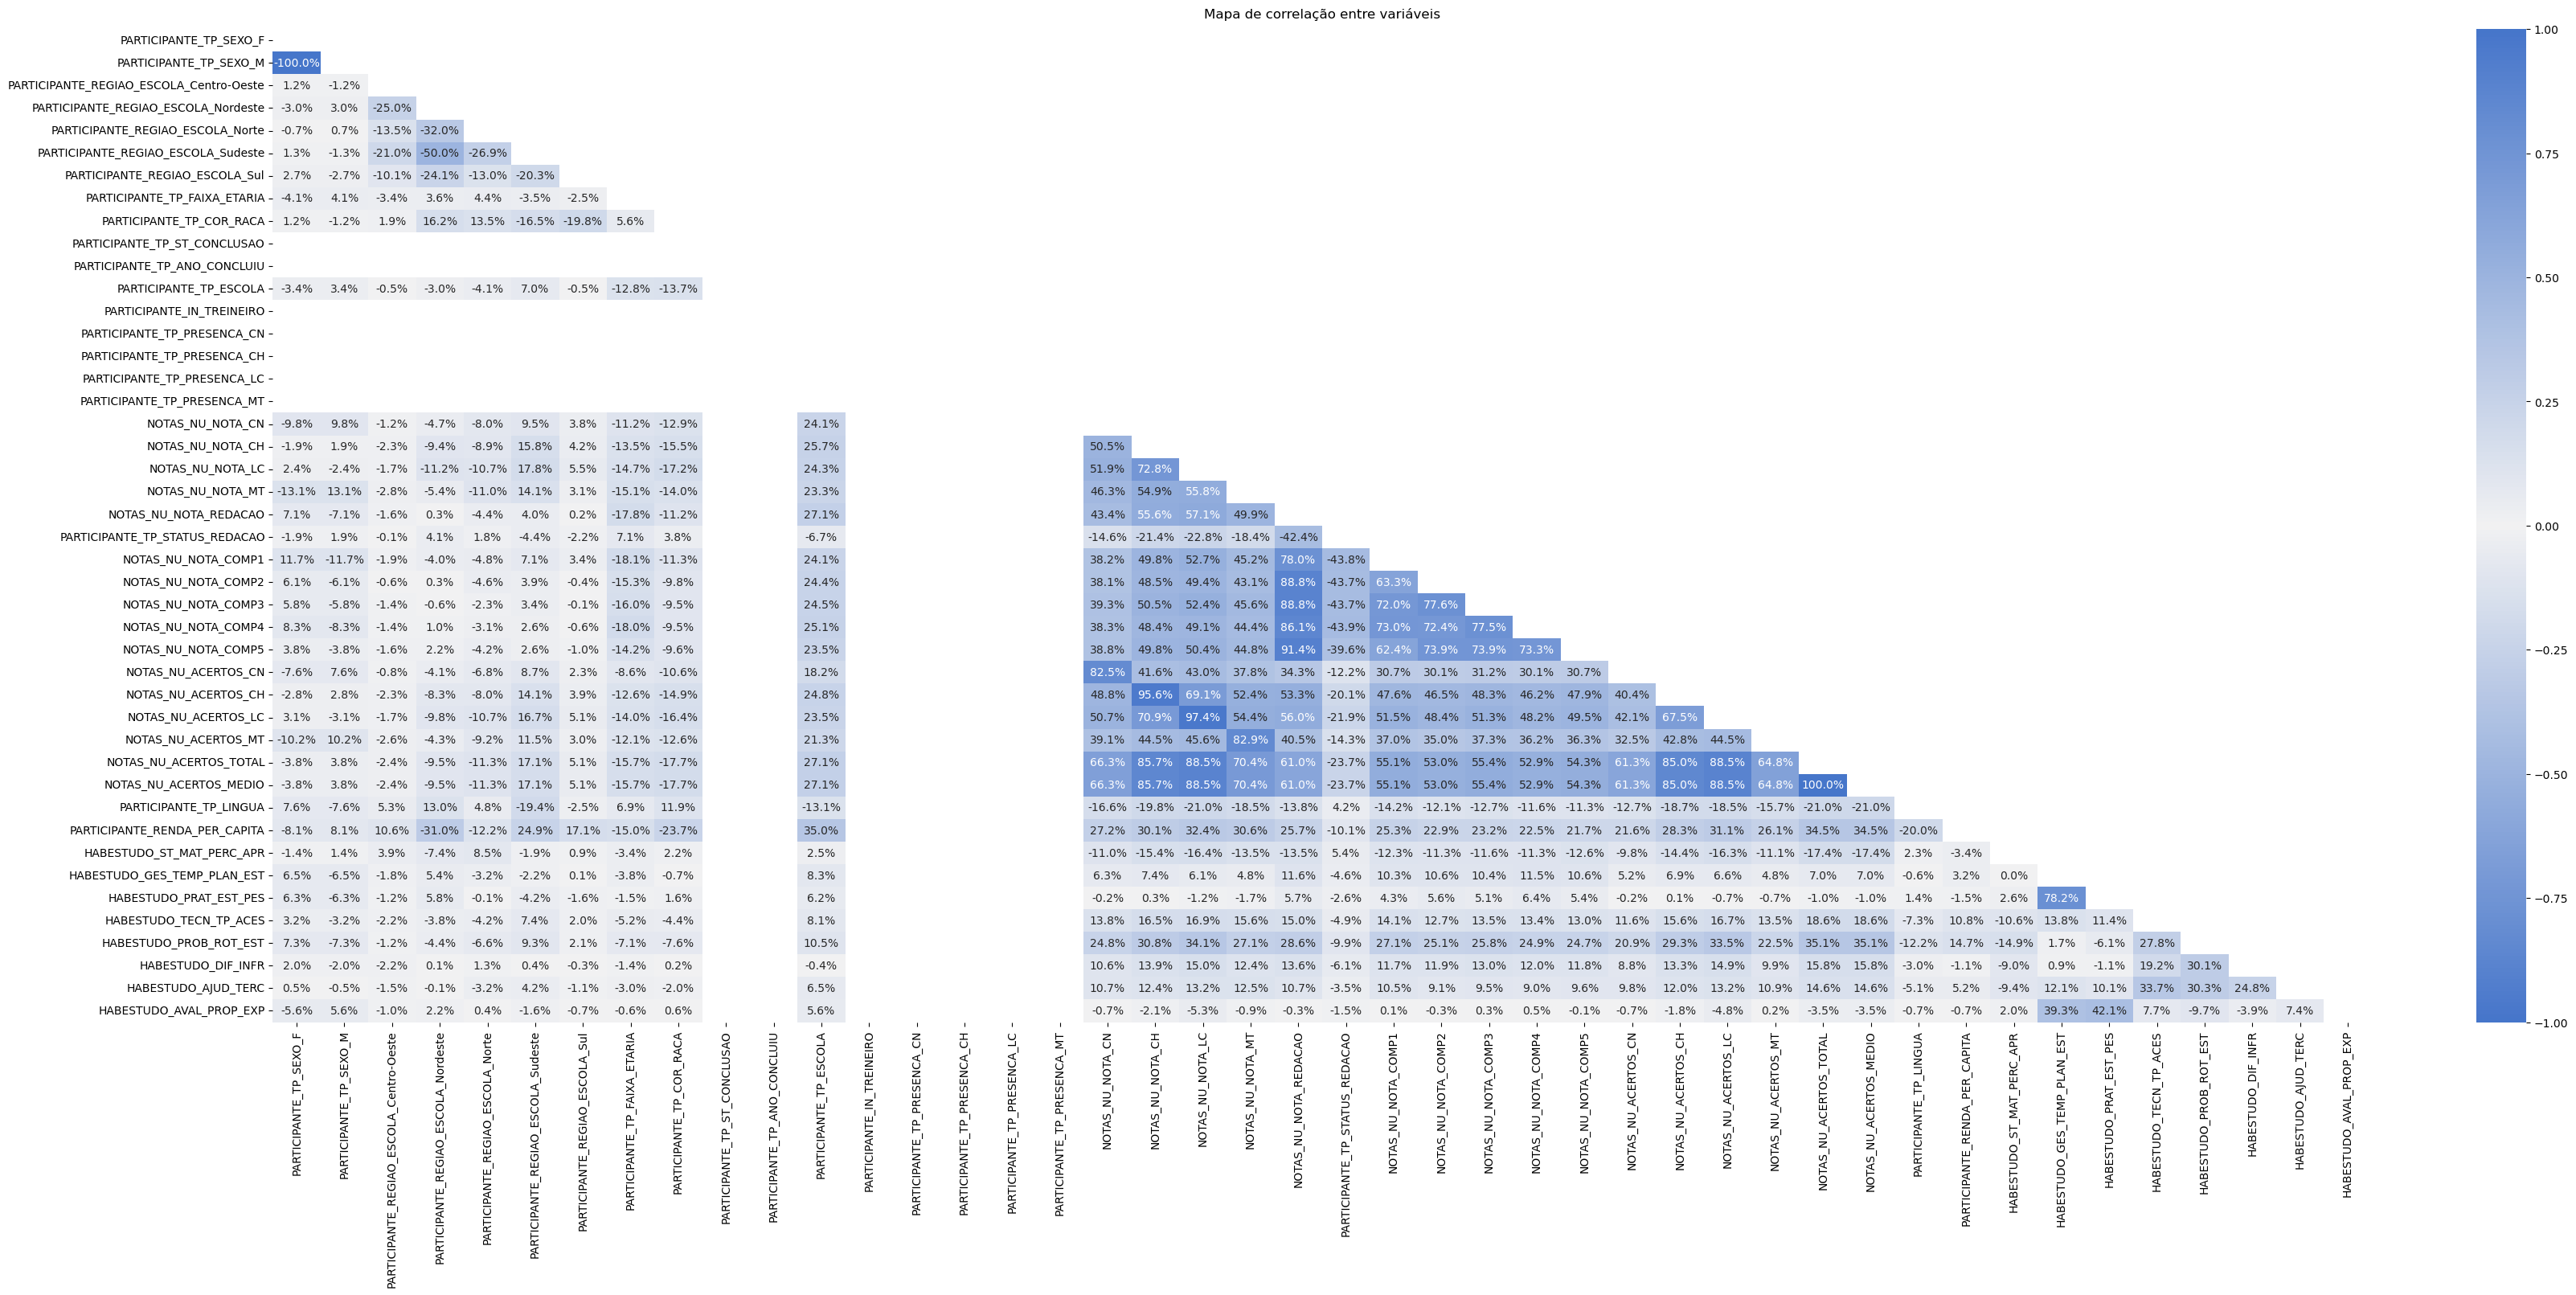

In [33]:
fig, ax = plt.subplots(figsize=(32, 16), constrained_layout=True)

plot_corr(ax, X_transformed, 'Mapa de correlação entre variáveis')
plt.show()

In [34]:
columns_to_drop = ['PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'PARTICIPANTE_TP_SEXO_M', 'NOTAS_NU_ACERTOS_MEDIO', 'NOTAS_NU_ACERTOS_CN', 'NOTAS_NU_ACERTOS_CH', 'NOTAS_NU_ACERTOS_LC', 'NOTAS_NU_ACERTOS_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'NOTAS_NU_ACERTOS_TOTAL', 'PARTICIPANTE_TP_LINGUA']

X_transformed_dropped = X_transformed.drop(columns=columns_to_drop)
X_transformed_dropped

,PARTICIPANTE_TP_SEXO_F,PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste,PARTICIPANTE_REGIAO_ESCOLA_Nordeste,PARTICIPANTE_REGIAO_ESCOLA_Norte,PARTICIPANTE_REGIAO_ESCOLA_Sudeste,PARTICIPANTE_REGIAO_ESCOLA_Sul,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,1363.50,3.30,3.32,8.36,4.0,7.0,3.0,4.5,0.25
1,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,1060.50,3.10,2.32,4.96,4.0,2.0,1.0,4.5,0.25
2,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0,681.75,3.10,2.99,5.64,2.0,2.0,3.0,3.5,0.25
3,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,1363.50,2.60,2.66,4.29,2.0,7.0,2.0,2.5,0.50
4,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,909.00,3.10,3.68,7.34,4.0,4.0,2.0,4.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,303.00,2.60,5.34,11.68,4.0,11.0,3.0,2.5,0.50
22829,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,202.00,3.10,3.00,8.70,3.0,2.0,3.0,3.5,0.00
22830,1.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0,545.40,3.35,1.66,3.98,2.0,3.0,2.0,3.5,0.25
22831,1.0,0.0,0.0,1.0,0.0,0.0,5.0,3.0,2.0,0.00,1.85,1.65,2.65,3.0,3.0,3.0,3.5,0.25


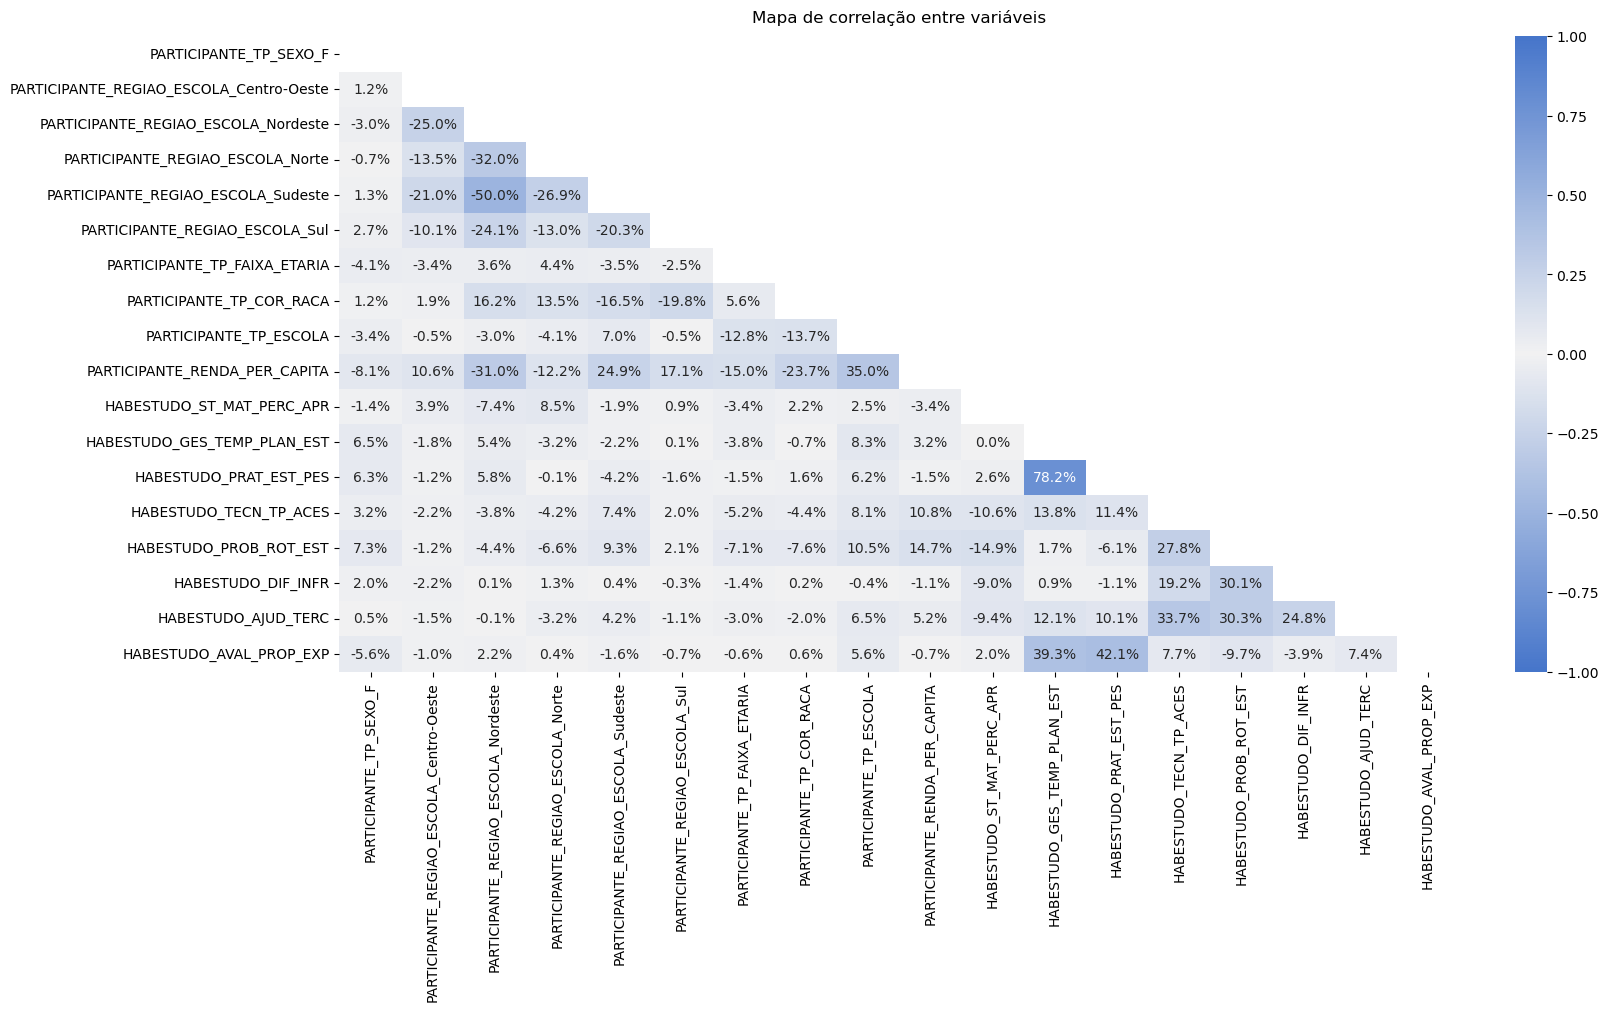

In [35]:
fig, ax = plt.subplots(figsize=(16, 10), constrained_layout=True)

plot_corr(ax, X_transformed_dropped, 'Mapa de correlação entre variáveis')
plt.show()

*Conclusões:*
- Linguagens e Humanas são as áreas que mais influenciam no número de acertos total;
- A competência 5 é a que mais influencia na nota de Redação;
- As categorias Gestão de Tempo e Planejamento de Estudos e Práticas de Estudo e Pesquisa são as mais relacionadas.

**Avaliando importância das variáveis**

In [36]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed_dropped, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed_dropped, y_categorical_transformed, test_size=0.3, random_state=SEED)

In [37]:
# accelerating sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Classificador

In [38]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [39]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=3))])

In [40]:
randomforest_classifier_accuracy_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='balanced_accuracy')
randomforest_classifier_accuracy_scores.mean()

0.39300776788835146

In [41]:
randomforest_classifier_precision_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='precision_weighted')
randomforest_classifier_precision_scores.mean()

0.38169531145394386

In [42]:
randomforest_classifier_recall_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='recall_weighted')
randomforest_classifier_recall_scores.mean()

0.39258982506144696

In [43]:
randomforest_classifier_f1_scores = cross_val_score(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cv=5, scoring='f1_weighted')
randomforest_classifier_f1_scores.mean()

0.3849796441459323

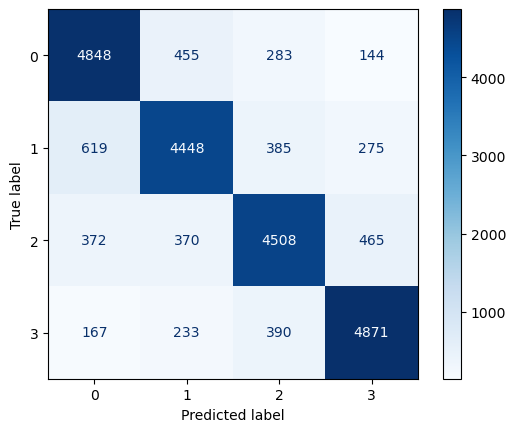

In [44]:
ConfusionMatrixDisplay.from_estimator(randomforest_classifier_pipe, X_transformed_dropped, y_categorical_transformed, cmap='Blues')
plt.show()

In [45]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

HABESTUDO_PRAT_EST_PES                     15.17
PARTICIPANTE_RENDA_PER_CAPITA              13.97
HABESTUDO_GES_TEMP_PLAN_EST                12.82
HABESTUDO_ST_MAT_PERC_APR                   9.22
HABESTUDO_PROB_ROT_EST                      8.46
PARTICIPANTE_TP_FAIXA_ETARIA                5.67
HABESTUDO_AVAL_PROP_EXP                     5.45
PARTICIPANTE_TP_COR_RACA                    4.88
HABESTUDO_AJUD_TERC                         4.87
HABESTUDO_TECN_TP_ACES                      4.52
PARTICIPANTE_TP_SEXO_F                      3.07
HABESTUDO_DIF_INFR                          2.25
PARTICIPANTE_TP_ESCOLA                      2.11
PARTICIPANTE_REGIAO_ESCOLA_Nordeste         1.96
PARTICIPANTE_REGIAO_ESCOLA_Sudeste          1.74
PARTICIPANTE_REGIAO_ESCOLA_Norte            1.41
PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste     1.26
PARTICIPANTE_REGIAO_ESCOLA_Sul              1.16
dtype: float64

Regressor

In [46]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [47]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [48]:
randomforest_regressor_mae_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
randomforest_regressor_mae_scores.mean()

56.85829337670386

In [49]:
randomforest_regressor_rmse_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
randomforest_regressor_rmse_scores.mean()

72.58942844637525

In [50]:
randomforest_regressor_r2_scores = cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='r2')
randomforest_regressor_r2_scores.mean()

0.27720976784963974

In [51]:
randomforest_regressor_mape_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed_dropped, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
randomforest_regressor_mape_scores.mean()

89773922506369.45

In [52]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances

HABESTUDO_PROB_ROT_EST                     14.96
HABESTUDO_PRAT_EST_PES                     14.21
PARTICIPANTE_RENDA_PER_CAPITA              14.02
HABESTUDO_GES_TEMP_PLAN_EST                11.18
HABESTUDO_ST_MAT_PERC_APR                   8.16
PARTICIPANTE_TP_ESCOLA                      7.42
PARTICIPANTE_TP_FAIXA_ETARIA                5.22
HABESTUDO_AVAL_PROP_EXP                     4.08
PARTICIPANTE_TP_COR_RACA                    3.98
HABESTUDO_TECN_TP_ACES                      3.26
HABESTUDO_AJUD_TERC                         3.26
PARTICIPANTE_TP_SEXO_F                      2.11
HABESTUDO_DIF_INFR                          1.85
PARTICIPANTE_REGIAO_ESCOLA_Nordeste         1.64
PARTICIPANTE_REGIAO_ESCOLA_Sudeste          1.47
PARTICIPANTE_REGIAO_ESCOLA_Norte            1.14
PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste     1.12
PARTICIPANTE_REGIAO_ESCOLA_Sul              0.93
dtype: float64

In [53]:
# decelerating sklearn
unpatch_sklearn()

**Utilizar hábitos de estudo mais significativos**

In [54]:
def get_interest_hab_estudo(filtered_df: pd.DataFrame, full_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Substitui as colunas de categoria dos hábitos de estudo mais significativas e deleta as não utilizadas.

    :params:
    - filtered_df: DataFrame previamente tratado com todos os dados para substituição.
    - full_df: DataFrame completo para extração das colunas individuais de hábitos de estudo.

    Returns a DataFrame.
    '''

    filtered_df = filtered_df.drop(columns=['HABESTUDO_ST_MAT_PERC_APR', 'HABESTUDO_TECN_TP_ACES', 'HABESTUDO_DIF_INFR', 'HABESTUDO_AJUD_TERC', 'HABESTUDO_AVAL_PROP_EXP'])


    hab_estudo_transformation_dict = {
        'HABESTUDO_GES_TEMP_PLAN_EST': {
            'HABESTUDO_Q005': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q006': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q007': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q008': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q021': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q022': ('A', 'B', 'C', 'D'),
            },
        'HABESTUDO_PRAT_EST_PES': {
            'HABESTUDO_Q009': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q010': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q011': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q012': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q013': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q014': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q015': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q016': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q017': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q018': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q019': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q020': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q023': ('A', 'B', 'C', 'D'),
            'HABESTUDO_Q024': ('A', 'B', 'C', 'D'),
            },
        'HABESTUDO_PROB_ROT_EST': {
            'HABESTUDO_Q027': ('B', 'A'),
            'HABESTUDO_Q028A': ('B', 'A'),
            'HABESTUDO_Q028B': ('B', 'A'),
            'HABESTUDO_Q028C': ('B', 'A'),
            'HABESTUDO_Q028D': ('B', 'A'),
            'HABESTUDO_Q028E': ('B', 'A'),
            'HABESTUDO_Q028F': ('B', 'A'),
            'HABESTUDO_Q028G': ('B', 'A'),
            'HABESTUDO_Q028H': ('B', 'A'),
            'HABESTUDO_Q028I': ('B', 'A'),
            'HABESTUDO_Q028J': ('B', 'A'),
            'HABESTUDO_Q028K': ('B', 'A'),
            'HABESTUDO_Q028L': ('B', 'A'),
            'HABESTUDO_Q028M': ('B', 'A'),
            'HABESTUDO_Q028N': ('B', 'A'),
            'HABESTUDO_Q028O': ('B', 'A'),
            'HABESTUDO_Q028P': ('B', 'A'),
            'HABESTUDO_Q028Q': ('B', 'A'),
            'HABESTUDO_Q028R': ('B', 'A'),
            },
    }

    hab_estudo_columns = [column for columns_dict in hab_estudo_transformation_dict.values() for column in columns_dict.keys()]
    hab_estudo_columns = ['NU_INSCRICAO'] + hab_estudo_columns

    filtered_df = filtered_df.join(full_df[hab_estudo_columns].set_index('NU_INSCRICAO'), on='NU_INSCRICAO', how='inner')
    filtered_df = filtered_df.drop(columns=hab_estudo_transformation_dict.keys())

    return filtered_df

In [55]:
complete_data = get_interest_hab_estudo(filtered_aggregated_df, aggregated_df)
complete_data

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ST_CONCLUSAO,PARTICIPANTE_TP_ANO_CONCLUIU,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_IN_TREINEIRO,PARTICIPANTE_REGIAO_ESCOLA,PARTICIPANTE_TP_PRESENCA_CN,...,HABESTUDO_Q028I,HABESTUDO_Q028J,HABESTUDO_Q028K,HABESTUDO_Q028L,HABESTUDO_Q028M,HABESTUDO_Q028N,HABESTUDO_Q028O,HABESTUDO_Q028P,HABESTUDO_Q028Q,HABESTUDO_Q028R
0,210055874527,2,F,1,2,0,2,0,Sudeste,1,...,B,A,B,B,B,B,B,B,B,B
1,210055928281,2,F,1,2,0,2,0,Sudeste,1,...,B,B,B,B,B,B,B,B,B,B
2,210055936729,2,M,1,2,0,3,0,Sudeste,1,...,B,B,B,B,B,B,B,B,B,B
3,210055940779,3,M,1,2,0,3,0,Sudeste,1,...,B,B,B,B,B,B,B,B,B,B
4,210055994174,2,F,1,2,0,2,0,Sudeste,1,...,A,B,A,B,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,210055704359,3,F,1,2,0,3,0,Sudeste,1,...,A,A,B,B,B,A,A,B,B,B
22829,210055736999,3,F,1,2,0,2,0,Nordeste,1,...,A,B,B,B,B,B,B,B,B,B
22830,210055757473,2,F,3,2,0,2,0,Sudeste,1,...,B,B,B,B,B,B,B,B,B,B
22831,210055758151,5,F,3,2,0,2,0,Norte,1,...,B,B,B,B,B,B,B,B,B,B


In [56]:
columns_to_drop = ['PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'NOTAS_NU_ACERTOS_MEDIO', 'NOTAS_NU_ACERTOS_CN', 'NOTAS_NU_ACERTOS_CH', 'NOTAS_NU_ACERTOS_LC', 'NOTAS_NU_ACERTOS_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'NOTAS_NU_ACERTOS_TOTAL', 'PARTICIPANTE_TP_LINGUA']

complete_data = complete_data.drop(columns=columns_to_drop)
complete_data

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_REGIAO_ESCOLA,NOTAS_NU_NOTA_MEDIA,NOTAS_NU_NOTA_CONCEITO,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_Q005,...,HABESTUDO_Q028I,HABESTUDO_Q028J,HABESTUDO_Q028K,HABESTUDO_Q028L,HABESTUDO_Q028M,HABESTUDO_Q028N,HABESTUDO_Q028O,HABESTUDO_Q028P,HABESTUDO_Q028Q,HABESTUDO_Q028R
0,210055874527,2,F,1,2,Sudeste,486.92,1,1363.50,B,...,B,A,B,B,B,B,B,B,B,B
1,210055928281,2,F,1,2,Sudeste,598.80,3,1060.50,C,...,B,B,B,B,B,B,B,B,B,B
2,210055936729,2,M,1,3,Sudeste,536.06,2,681.75,B,...,B,B,B,B,B,B,B,B,B,B
3,210055940779,3,M,1,3,Sudeste,544.16,2,1363.50,B,...,B,B,B,B,B,B,B,B,B,B
4,210055994174,2,F,1,2,Sudeste,529.80,2,909.00,C,...,A,B,A,B,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,210055704359,3,F,1,3,Sudeste,652.74,3,303.00,C,...,A,A,B,B,B,A,A,B,B,B
22829,210055736999,3,F,1,2,Nordeste,515.34,2,202.00,C,...,A,B,B,B,B,B,B,B,B,B
22830,210055757473,2,F,3,2,Sudeste,499.60,1,545.40,B,...,B,B,B,B,B,B,B,B,B,B
22831,210055758151,5,F,3,2,Norte,414.04,0,0.00,B,...,B,B,B,B,B,B,B,B,B,B


In [ ]:
complete_data.to_csv('../complete_df.csv', index=False)

In [ ]:
complete_data_creation_query = '''
CREATE TABLE projeto_enem.complete_data (
	"NU_INSCRICAO" BIGINT PRIMARY KEY,
	"PARTICIPANTE_TP_FAIXA_ETARIA" INTEGER,
	"PARTICIPANTE_TP_SEXO" VARCHAR(1),
	"PARTICIPANTE_TP_COR_RACA" INTEGER,
	"PARTICIPANTE_TP_ESCOLA" INTEGER,
	"PARTICIPANTE_REGIAO_ESCOLA" VARCHAR(12),
	"NOTAS_NU_NOTA_MEDIA" FLOAT,
    "NOTAS_NU_NOTA_CONCEITO" INTEGER,
	"PARTICIPANTE_RENDA_PER_CAPITA" FLOAT,
	"HABESTUDO_Q005" VARCHAR(1),
	"HABESTUDO_Q006" VARCHAR(1),
	"HABESTUDO_Q007" VARCHAR(1),
	"HABESTUDO_Q008" VARCHAR(1),
	"HABESTUDO_Q021" VARCHAR(1),
	"HABESTUDO_Q022" VARCHAR(1),
	"HABESTUDO_Q009" VARCHAR(1),
	"HABESTUDO_Q010" VARCHAR(1),
	"HABESTUDO_Q011" VARCHAR(1),
	"HABESTUDO_Q012" VARCHAR(1),
	"HABESTUDO_Q013" VARCHAR(1),
	"HABESTUDO_Q014" VARCHAR(1),
	"HABESTUDO_Q015" VARCHAR(1),
	"HABESTUDO_Q016" VARCHAR(1),
	"HABESTUDO_Q017" VARCHAR(1),
	"HABESTUDO_Q018" VARCHAR(1),
	"HABESTUDO_Q019" VARCHAR(1),
	"HABESTUDO_Q020" VARCHAR(1),
	"HABESTUDO_Q023" VARCHAR(1),
	"HABESTUDO_Q024" VARCHAR(1),
	"HABESTUDO_Q027" VARCHAR(1),
	"HABESTUDO_Q028A" VARCHAR(1),
	"HABESTUDO_Q028B" VARCHAR(1),
	"HABESTUDO_Q028C" VARCHAR(1),
	"HABESTUDO_Q028D" VARCHAR(1),
	"HABESTUDO_Q028E" VARCHAR(1),
	"HABESTUDO_Q028F" VARCHAR(1),
	"HABESTUDO_Q028G" VARCHAR(1),
	"HABESTUDO_Q028H" VARCHAR(1),
	"HABESTUDO_Q028I" VARCHAR(1),
	"HABESTUDO_Q028J" VARCHAR(1),
	"HABESTUDO_Q028K" VARCHAR(1),
	"HABESTUDO_Q028L" VARCHAR(1),
	"HABESTUDO_Q028M" VARCHAR(1),
	"HABESTUDO_Q028N" VARCHAR(1),
	"HABESTUDO_Q028O" VARCHAR(1),
	"HABESTUDO_Q028P" VARCHAR(1),
	"HABESTUDO_Q028Q" VARCHAR(1),
	"HABESTUDO_Q028R" VARCHAR(1)
);
'''

complete_data_csv_query = '''
COPY projeto_enem.complete_data("NU_INSCRICAO", "PARTICIPANTE_TP_FAIXA_ETARIA", "PARTICIPANTE_TP_SEXO", "PARTICIPANTE_TP_COR_RACA", "PARTICIPANTE_TP_ESCOLA", "PARTICIPANTE_REGIAO_ESCOLA", "NOTAS_NU_NOTA_MEDIA", "NOTAS_NU_NOTA_CONCEITO", "PARTICIPANTE_RENDA_PER_CAPITA", "HABESTUDO_Q005", "HABESTUDO_Q006", "HABESTUDO_Q007", "HABESTUDO_Q008", "HABESTUDO_Q021", "HABESTUDO_Q022", "HABESTUDO_Q009", "HABESTUDO_Q010", "HABESTUDO_Q011", "HABESTUDO_Q012", "HABESTUDO_Q013", "HABESTUDO_Q014", "HABESTUDO_Q015", "HABESTUDO_Q016", "HABESTUDO_Q017", "HABESTUDO_Q018", "HABESTUDO_Q019", "HABESTUDO_Q020", "HABESTUDO_Q023", "HABESTUDO_Q024", "HABESTUDO_Q027", "HABESTUDO_Q028A", "HABESTUDO_Q028B", "HABESTUDO_Q028C", "HABESTUDO_Q028D", "HABESTUDO_Q028E", "HABESTUDO_Q028F", "HABESTUDO_Q028G", "HABESTUDO_Q028H", "HABESTUDO_Q028I", "HABESTUDO_Q028J", "HABESTUDO_Q028K", "HABESTUDO_Q028L", "HABESTUDO_Q028M", "HABESTUDO_Q028N", "HABESTUDO_Q028O", "HABESTUDO_Q028P", "HABESTUDO_Q028Q", "HABESTUDO_Q028R")
FROM STDIN
WITH (DELIMITER ',',
ENCODING 'utf8',
FORMAT CSV,
HEADER);
'''


with db_connection() as conn, conn.cursor() as cursor:
    cursor.execute(complete_data_creation_query)
    conn.commit()
    
    with open('../complete_df.csv', encoding='utf8') as complete_data_csv_file:
        cursor.copy_expert(complete_data_csv_query, complete_data_csv_file)
        conn.commit()

**Analisando importância das novas variáveis**

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.complete_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''

    cursor.execute(query)
    complete_data_fetched = cursor.fetchall()
    complete_data_columns = tuple(desc[0] for desc in cursor.description)


complete_data = pd.DataFrame(complete_data_fetched, columns=complete_data_columns)
complete_data

**ordinal:** 'HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R'

**nominal:** 'PARTICIPANTE_TP_SEXO', 'PARTICIPANTE_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'PARTICIPANTE_TP_FAIXA_ETARIA', 'PARTICIPANTE_TP_COR_RACA', 'PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_TP_ESCOLA', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO', 'NOTAS_NU_ACERTOS_CN', 'NOTAS_NU_ACERTOS_CH', 'NOTAS_NU_ACERTOS_LC', 'NOTAS_NU_ACERTOS_MT', 'NOTAS_NU_ACERTOS_TOTAL', 'NOTAS_NU_ACERTOS_MEDIO', 'PARTICIPANTE_TP_LINGUA', 'PARTICIPANTE_RENDA_PER_CAPITA'

In [57]:
ordinal_features = ['HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R']
nominal_features = list(set(complete_data.select_dtypes(include='object').columns.values) - set(ordinal_features))
numerical_features = list(set(complete_data.select_dtypes(exclude='object').columns.values) - set(ordinal_features))

In [58]:
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q005
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q006
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q007
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q008
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q021
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q022
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q009
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q010
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q011
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q012
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q013
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q014
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q015
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q016
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q017
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q018
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q019
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q020
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q023
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q024
        ('B', 'A'),   # HABESTUDO_Q027
        ('B', 'A'),   # HABESTUDO_Q028A
        ('B', 'A'),   # HABESTUDO_Q028B
        ('B', 'A'),   # HABESTUDO_Q028C
        ('B', 'A'),   # HABESTUDO_Q028D
        ('B', 'A'),   # HABESTUDO_Q028E
        ('B', 'A'),   # HABESTUDO_Q028F
        ('B', 'A'),   # HABESTUDO_Q028G
        ('B', 'A'),   # HABESTUDO_Q028H
        ('B', 'A'),   # HABESTUDO_Q028I
        ('B', 'A'),   # HABESTUDO_Q028J
        ('B', 'A'),   # HABESTUDO_Q028K
        ('B', 'A'),   # HABESTUDO_Q028L
        ('B', 'A'),   # HABESTUDO_Q028M
        ('B', 'A'),   # HABESTUDO_Q028N
        ('B', 'A'),   # HABESTUDO_Q028O
        ('B', 'A'),   # HABESTUDO_Q028P
        ('B', 'A'),   # HABESTUDO_Q028Q
        ('B', 'A'),   # HABESTUDO_Q028R
    ])),
])

nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

In [59]:
X = complete_data.drop(columns=['NU_INSCRICAO', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO'])

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = complete_data['NOTAS_NU_NOTA_MEDIA']
y_categorical_transformed = complete_data['NOTAS_NU_NOTA_CONCEITO']

In [60]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [61]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed = X_transformed.drop(columns='PARTICIPANTE_TP_SEXO_M').reset_index(drop=True)
X_transformed

,HABESTUDO_Q005,HABESTUDO_Q006,HABESTUDO_Q007,HABESTUDO_Q008,HABESTUDO_Q021,HABESTUDO_Q022,HABESTUDO_Q009,HABESTUDO_Q010,HABESTUDO_Q011,HABESTUDO_Q012,...,PARTICIPANTE_TP_SEXO_F,PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste,PARTICIPANTE_REGIAO_ESCOLA_Nordeste,PARTICIPANTE_REGIAO_ESCOLA_Norte,PARTICIPANTE_REGIAO_ESCOLA_Sudeste,PARTICIPANTE_REGIAO_ESCOLA_Sul,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_TP_ESCOLA,PARTICIPANTE_RENDA_PER_CAPITA
0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,1363.50
1,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,1060.50
2,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0,681.75
3,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,1363.50
4,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,909.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22828,2.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,303.00
22829,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,202.00
22830,1.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0,545.40
22831,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,5.0,3.0,2.0,0.00


In [62]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed, y_categorical_transformed, test_size=0.3, random_state=SEED)

In [63]:
# accelerating sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Classificador

In [64]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [65]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=3))])

In [66]:
randomforest_classifier_accuracy_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='balanced_accuracy')
randomforest_classifier_accuracy_scores.mean()

0.40108686265043253

In [67]:
randomforest_classifier_precision_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
randomforest_classifier_precision_scores.mean()

0.3895439196130544

In [68]:
randomforest_classifier_recall_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
randomforest_classifier_recall_scores.mean()

0.40064749678726086

In [69]:
randomforest_classifier_f1_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
randomforest_classifier_f1_scores.mean()

0.39304137845788356

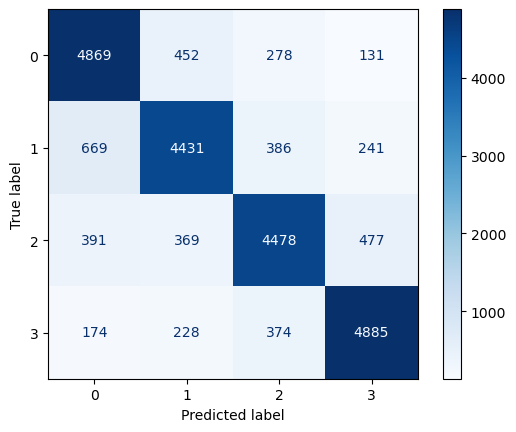

In [70]:
ConfusionMatrixDisplay.from_estimator(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [71]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

PARTICIPANTE_RENDA_PER_CAPITA              10.39
PARTICIPANTE_TP_FAIXA_ETARIA                4.27
PARTICIPANTE_TP_COR_RACA                    3.70
HABESTUDO_Q021                              3.14
HABESTUDO_Q022                              3.06
HABESTUDO_Q013                              2.84
HABESTUDO_Q019                              2.82
HABESTUDO_Q024                              2.78
HABESTUDO_Q005                              2.77
HABESTUDO_Q020                              2.67
HABESTUDO_Q009                              2.66
HABESTUDO_Q011                              2.63
HABESTUDO_Q012                              2.62
HABESTUDO_Q010                              2.62
HABESTUDO_Q007                              2.57
HABESTUDO_Q014                              2.53
HABESTUDO_Q008                              2.52
HABESTUDO_Q023                              2.50
HABESTUDO_Q017                              2.48
HABESTUDO_Q018                              2.48
HABESTUDO_Q006      

Regressor

In [72]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [73]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [74]:
randomforest_regressor_mae_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
randomforest_regressor_mae_scores.mean()

56.3757341484414

In [75]:
randomforest_regressor_rmse_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
randomforest_regressor_rmse_scores.mean()

72.11882797641377

In [76]:
randomforest_regressor_r2_scores = cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
randomforest_regressor_r2_scores.mean()

0.28650148455598723

In [77]:
randomforest_regressor_mape_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
randomforest_regressor_mape_scores.mean()

88778830173460.67

In [78]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances

PARTICIPANTE_RENDA_PER_CAPITA              12.65
PARTICIPANTE_TP_ESCOLA                      8.37
HABESTUDO_Q028G                             7.76
PARTICIPANTE_TP_FAIXA_ETARIA                4.47
PARTICIPANTE_TP_COR_RACA                    3.24
HABESTUDO_Q021                              2.53
HABESTUDO_Q020                              2.48
HABESTUDO_Q019                              2.41
HABESTUDO_Q011                              2.30
HABESTUDO_Q028C                             2.27
HABESTUDO_Q007                              2.27
HABESTUDO_Q022                              2.23
HABESTUDO_Q005                              2.18
HABESTUDO_Q018                              2.17
HABESTUDO_Q024                              2.17
HABESTUDO_Q013                              2.16
HABESTUDO_Q014                              2.02
HABESTUDO_Q017                              2.01
HABESTUDO_Q008                              2.00
HABESTUDO_Q006                              1.96
HABESTUDO_Q009      

In [79]:
# decelerating sklearn
unpatch_sklearn()

In [80]:
randomforest_feature_importances = pd.concat([pd.DataFrame(randomforest_classifier_feature_importances, columns=['classifier_importance']).reset_index(names='classifier_column'), pd.DataFrame(randomforest_regressor_feature_importances, columns=['regressor_importance']).reset_index(names='regressor_column')], axis=1).sort_values(['classifier_importance', 'regressor_importance'], ascending=False)
randomforest_feature_importances

,classifier_column,classifier_importance,regressor_column,regressor_importance
0,PARTICIPANTE_RENDA_PER_CAPITA,10.39,PARTICIPANTE_RENDA_PER_CAPITA,12.65
1,PARTICIPANTE_TP_FAIXA_ETARIA,4.27,PARTICIPANTE_TP_ESCOLA,8.37
2,PARTICIPANTE_TP_COR_RACA,3.70,HABESTUDO_Q028G,7.76
3,HABESTUDO_Q021,3.14,PARTICIPANTE_TP_FAIXA_ETARIA,4.47
4,HABESTUDO_Q022,3.06,PARTICIPANTE_TP_COR_RACA,3.24
5,HABESTUDO_Q013,2.84,HABESTUDO_Q021,2.53
6,HABESTUDO_Q019,2.82,HABESTUDO_Q020,2.48
7,HABESTUDO_Q024,2.78,HABESTUDO_Q019,2.41
8,HABESTUDO_Q005,2.77,HABESTUDO_Q011,2.30
9,HABESTUDO_Q020,2.67,HABESTUDO_Q028C,2.27


In [81]:
def get_hab_estudo_correspondent_column_names(df: pd.DataFrame, changing_columns: list) -> pd.DataFrame:
    '''
    Substitui as colunas de categoria dos hábitos de estudo pelo seu significado.

    :params:
    - df: DataFrame previamente tratado com todos os dados para substituição.
    - changing_columns: colunas com dados para serem alterados.

    Returns a DataFrame.
    '''

    hab_estudo_column_correspondent_names = {
        'HABESTUDO_Q005': 'Organizei cronograma de estudos com tempos mais longos e mais curtos para estudar de acordo com a dificuldade das matérias',
        'HABESTUDO_Q006': 'Reservei tempos mais longos e mais curtos para estudar de acordo com a dificuldade das matérias',
        'HABESTUDO_Q007': 'Organizei material para ser estudado',
        'HABESTUDO_Q008': 'Eu me dediquei aos horários programados de estudo de acordo com a dificuldade das matérias',
        'HABESTUDO_Q021': 'Entrei nas aulas online por videoconferência sem atraso da minha parte',
        'HABESTUDO_Q022': 'Assisti todas as aulas online nas datas programadas para estudo',
        'HABESTUDO_Q009': 'Li os textos indicados em cada matéria antes de assistir as aulas ou videoaulas sobre o assunto dos textos',
        'HABESTUDO_Q010': 'Resumi os textos das matérias, destacando as partes mais importantes',
        'HABESTUDO_Q011': 'Resumi as videoaulas ou os podcasts, destacando as partes mais importantes',
        'HABESTUDO_Q012': 'Fiz as atividades das matérias para fixação de conteúdo',
        'HABESTUDO_Q013': 'Fiz atividades avaliativas, inclusive simulados, para verificar o quanto aprendi durante a pandemia',
        'HABESTUDO_Q014': 'Aproveitei o tempo das aulas online ou atividades de reforço, sem desperdiçá-lo com distrações',
        'HABESTUDO_Q015': 'Anotei as explicações obtidas em videoaulas ou podcasts das matérias',
        'HABESTUDO_Q016': 'Anotei as informações que obtive ao assistir vídeos complementares de assuntos do meu interesse',
        'HABESTUDO_Q017': 'Destaquei as dúvidas que tive ao ler os textos das disciplinas para esclarecer com os professores',
        'HABESTUDO_Q018': 'Estruturei as principais ideias para produzir redações',
        'HABESTUDO_Q019': 'Treinei redação',
        'HABESTUDO_Q020': 'Participei de fóruns de discussão por matéria para tirar dúvidas',
        'HABESTUDO_Q023': 'Revisei as anotações das aulas, os resumos e anotações dos demais materiais que li ou assisti',
        'HABESTUDO_Q024': 'Reassisti as videoaulas e os podcasts das matérias',
        'HABESTUDO_Q027': 'Você vivenciou problemas em sua rotina para estudar ou manter-se informado(a) durante a pandemia?',
        'HABESTUDO_Q028A': 'Eu me senti desestimulado(a) por não ter colegas com quem interagir sobre o que eu estava estudando',
        'HABESTUDO_Q028B': 'Tive dificuldade de compreender os conteúdos por falta de explicações de um professor em tempo real',
        'HABESTUDO_Q028C': 'Fiquei por muito tempo diante das telas, sem pequenos intervalos para descansar',
        'HABESTUDO_Q028D': 'Reduzi a prática de atividades físicas',
        'HABESTUDO_Q028E': 'Dormi por menos tempo',
        'HABESTUDO_Q028F': 'Tive episódios de insônia',
        'HABESTUDO_Q028G': 'Senti dificuldade em manter a motivação para estudar por minha conta',
        'HABESTUDO_Q028H': 'Senti dificuldade em me motivar a cumprir meu cronograma',
        'HABESTUDO_Q028I': 'Senti medo de não conseguir aprender os conteúdos',
        'HABESTUDO_Q028J': 'Senti ansiedade devido ao isolamento social e ao receio de contágio da doença',
        'HABESTUDO_Q028K': 'Dediquei tempo para ajudar algum familiar a estudar em casa',
        'HABESTUDO_Q028L': 'Precisei ficar em repouso porque tive Covid com sintomas',
        'HABESTUDO_Q028M': 'Precisei ficar em repouso porque tive outra doença',
        'HABESTUDO_Q028N': 'Precisei cuidar de algum familiar que teve Covid com sintomas',
        'HABESTUDO_Q028O': 'Precisei cuidar de algum familiar que teve outra doença',
        'HABESTUDO_Q028P': 'Tive que cuidar do(s) meu(s) irmão(s) menor(es) para meus pais trabalharem',
        'HABESTUDO_Q028Q': 'Tive que começar a trabalhar em casa para obter renda',
        'HABESTUDO_Q028R': 'Tive que trabalhar em serviço considerado essencial durante a pandemia',
    }

    for column in changing_columns:
        df.loc[:, column] = df[column].replace(hab_estudo_column_correspondent_names)

    return df

In [82]:
randomforest_feature_importances = get_hab_estudo_correspondent_column_names(randomforest_feature_importances, ['classifier_column', 'regressor_column'])
randomforest_feature_importances

,classifier_column,classifier_importance,regressor_column,regressor_importance
0,PARTICIPANTE_RENDA_PER_CAPITA,10.39,PARTICIPANTE_RENDA_PER_CAPITA,12.65
1,PARTICIPANTE_TP_FAIXA_ETARIA,4.27,PARTICIPANTE_TP_ESCOLA,8.37
2,PARTICIPANTE_TP_COR_RACA,3.70,Senti dificuldade em manter a motivação para e...,7.76
3,Entrei nas aulas online por videoconferência s...,3.14,PARTICIPANTE_TP_FAIXA_ETARIA,4.47
4,Assisti todas as aulas online nas datas progra...,3.06,PARTICIPANTE_TP_COR_RACA,3.24
5,"Fiz atividades avaliativas, inclusive simulado...",2.84,Entrei nas aulas online por videoconferência s...,2.53
6,Treinei redação,2.82,Participei de fóruns de discussão por matéria ...,2.48
7,Reassisti as videoaulas e os podcasts das maté...,2.78,Treinei redação,2.41
8,Organizei cronograma de estudos com tempos mai...,2.77,"Resumi as videoaulas ou os podcasts, destacand...",2.30
9,Participei de fóruns de discussão por matéria ...,2.67,"Fiquei por muito tempo diante das telas, sem p...",2.27


In [83]:
randomforest_feature_importances[['regressor_column', 'regressor_importance']]

,regressor_column,regressor_importance
0,PARTICIPANTE_RENDA_PER_CAPITA,12.65
1,PARTICIPANTE_TP_ESCOLA,8.37
2,Senti dificuldade em manter a motivação para e...,7.76
3,PARTICIPANTE_TP_FAIXA_ETARIA,4.47
4,PARTICIPANTE_TP_COR_RACA,3.24
5,Entrei nas aulas online por videoconferência s...,2.53
6,Participei de fóruns de discussão por matéria ...,2.48
7,Treinei redação,2.41
8,"Resumi as videoaulas ou os podcasts, destacand...",2.30
9,"Fiquei por muito tempo diante das telas, sem p...",2.27


**Analisando importância em escola particular**

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.complete_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''

    cursor.execute(query)
    complete_data_fetched = cursor.fetchall()
    complete_data_columns = tuple(desc[0] for desc in cursor.description)


complete_data = pd.DataFrame(complete_data_fetched, columns=complete_data_columns)
complete_data

In [85]:
complete_data_private = complete_data[complete_data['PARTICIPANTE_TP_ESCOLA'] == 3]
complete_data_private = complete_data_private.drop(columns='PARTICIPANTE_TP_ESCOLA')
complete_data_private

,NU_INSCRICAO,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_SEXO,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_REGIAO_ESCOLA,NOTAS_NU_NOTA_MEDIA,NOTAS_NU_NOTA_CONCEITO,PARTICIPANTE_RENDA_PER_CAPITA,HABESTUDO_Q005,HABESTUDO_Q006,...,HABESTUDO_Q028I,HABESTUDO_Q028J,HABESTUDO_Q028K,HABESTUDO_Q028L,HABESTUDO_Q028M,HABESTUDO_Q028N,HABESTUDO_Q028O,HABESTUDO_Q028P,HABESTUDO_Q028Q,HABESTUDO_Q028R
2,210055936729,2,M,1,Sudeste,536.06,2,681.75,B,B,...,B,B,B,B,B,B,B,B,B,B
3,210055940779,3,M,1,Sudeste,544.16,2,1363.50,B,B,...,B,B,B,B,B,B,B,B,B,B
19,210057084131,2,F,3,Nordeste,705.58,3,121.20,B,B,...,B,B,B,B,B,B,A,B,B,B
27,210057524241,1,F,3,Nordeste,664.56,3,476.14,B,A,...,B,B,B,B,B,B,B,B,B,B
30,210057577696,2,F,3,Sul,452.50,0,1414.00,B,C,...,B,B,B,B,B,B,B,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22805,210054791680,2,M,3,Nordeste,602.26,3,1515.00,A,B,...,A,A,B,B,A,B,B,B,B,B
22823,210055395496,2,M,1,Nordeste,496.02,1,1060.50,C,C,...,B,B,B,B,B,B,B,B,B,B
22824,210055398676,2,F,1,Nordeste,668.58,3,1818.00,B,B,...,B,A,B,B,B,B,B,B,B,B
22828,210055704359,3,F,1,Sudeste,652.74,3,303.00,C,C,...,A,A,B,B,B,A,A,B,B,B


**ordinal:** 'HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R'

**nominal:** 'PARTICIPANTE_TP_SEXO', 'PARTICIPANTE_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'PARTICIPANTE_TP_FAIXA_ETARIA', 'PARTICIPANTE_TP_COR_RACA', 'PARTICIPANTE_TP_ST_CONCLUSAO', 'PARTICIPANTE_TP_ANO_CONCLUIU', 'PARTICIPANTE_TP_ESCOLA', 'PARTICIPANTE_IN_TREINEIRO', 'PARTICIPANTE_TP_PRESENCA_CN', 'PARTICIPANTE_TP_PRESENCA_CH', 'PARTICIPANTE_TP_PRESENCA_LC', 'PARTICIPANTE_TP_PRESENCA_MT', 'NOTAS_NU_NOTA_CN', 'NOTAS_NU_NOTA_CH', 'NOTAS_NU_NOTA_LC', 'NOTAS_NU_NOTA_MT', 'NOTAS_NU_NOTA_REDACAO', 'PARTICIPANTE_TP_STATUS_REDACAO', 'NOTAS_NU_NOTA_COMP1', 'NOTAS_NU_NOTA_COMP2', 'NOTAS_NU_NOTA_COMP3', 'NOTAS_NU_NOTA_COMP4', 'NOTAS_NU_NOTA_COMP5', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO', 'NOTAS_NU_ACERTOS_CN', 'NOTAS_NU_ACERTOS_CH', 'NOTAS_NU_ACERTOS_LC', 'NOTAS_NU_ACERTOS_MT', 'NOTAS_NU_ACERTOS_TOTAL', 'NOTAS_NU_ACERTOS_MEDIO', 'PARTICIPANTE_TP_LINGUA', 'PARTICIPANTE_RENDA_PER_CAPITA'

In [86]:
ordinal_features = ['HABESTUDO_Q005', 'HABESTUDO_Q006', 'HABESTUDO_Q007', 'HABESTUDO_Q008', 'HABESTUDO_Q021', 'HABESTUDO_Q022', 'HABESTUDO_Q009', 'HABESTUDO_Q010', 'HABESTUDO_Q011', 'HABESTUDO_Q012', 'HABESTUDO_Q013', 'HABESTUDO_Q014', 'HABESTUDO_Q015', 'HABESTUDO_Q016', 'HABESTUDO_Q017', 'HABESTUDO_Q018', 'HABESTUDO_Q019', 'HABESTUDO_Q020', 'HABESTUDO_Q023', 'HABESTUDO_Q024', 'HABESTUDO_Q027', 'HABESTUDO_Q028A', 'HABESTUDO_Q028B', 'HABESTUDO_Q028C', 'HABESTUDO_Q028D', 'HABESTUDO_Q028E', 'HABESTUDO_Q028F', 'HABESTUDO_Q028G', 'HABESTUDO_Q028H', 'HABESTUDO_Q028I', 'HABESTUDO_Q028J', 'HABESTUDO_Q028K', 'HABESTUDO_Q028L', 'HABESTUDO_Q028M', 'HABESTUDO_Q028N', 'HABESTUDO_Q028O', 'HABESTUDO_Q028P', 'HABESTUDO_Q028Q', 'HABESTUDO_Q028R']
nominal_features = list(set(complete_data.select_dtypes(include='object').columns.values) - set(ordinal_features))
numerical_features = list(set(complete_data.select_dtypes(exclude='object').columns.values) - set(ordinal_features))

In [87]:
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q005
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q006
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q007
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q008
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q021
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q022
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q009
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q010
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q011
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q012
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q013
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q014
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q015
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q016
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q017
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q018
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q019
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q020
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q023
        ('A', 'B', 'C', 'D'),   # HABESTUDO_Q024
        ('B', 'A'),   # HABESTUDO_Q027
        ('B', 'A'),   # HABESTUDO_Q028A
        ('B', 'A'),   # HABESTUDO_Q028B
        ('B', 'A'),   # HABESTUDO_Q028C
        ('B', 'A'),   # HABESTUDO_Q028D
        ('B', 'A'),   # HABESTUDO_Q028E
        ('B', 'A'),   # HABESTUDO_Q028F
        ('B', 'A'),   # HABESTUDO_Q028G
        ('B', 'A'),   # HABESTUDO_Q028H
        ('B', 'A'),   # HABESTUDO_Q028I
        ('B', 'A'),   # HABESTUDO_Q028J
        ('B', 'A'),   # HABESTUDO_Q028K
        ('B', 'A'),   # HABESTUDO_Q028L
        ('B', 'A'),   # HABESTUDO_Q028M
        ('B', 'A'),   # HABESTUDO_Q028N
        ('B', 'A'),   # HABESTUDO_Q028O
        ('B', 'A'),   # HABESTUDO_Q028P
        ('B', 'A'),   # HABESTUDO_Q028Q
        ('B', 'A'),   # HABESTUDO_Q028R
    ])),
])

nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

In [88]:
X = complete_data_private.drop(columns=['NU_INSCRICAO', 'NOTAS_NU_NOTA_MEDIA', 'NOTAS_NU_NOTA_CONCEITO'])

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = complete_data_private['NOTAS_NU_NOTA_MEDIA']
y_categorical_transformed = complete_data_private['NOTAS_NU_NOTA_CONCEITO']

In [89]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [90]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed = X_transformed.drop(columns='PARTICIPANTE_TP_SEXO_M').reset_index(drop=True)
X_transformed

,HABESTUDO_Q005,HABESTUDO_Q006,HABESTUDO_Q007,HABESTUDO_Q008,HABESTUDO_Q021,HABESTUDO_Q022,HABESTUDO_Q009,HABESTUDO_Q010,HABESTUDO_Q011,HABESTUDO_Q012,...,HABESTUDO_Q028R,PARTICIPANTE_TP_SEXO_F,PARTICIPANTE_REGIAO_ESCOLA_Centro-Oeste,PARTICIPANTE_REGIAO_ESCOLA_Nordeste,PARTICIPANTE_REGIAO_ESCOLA_Norte,PARTICIPANTE_REGIAO_ESCOLA_Sudeste,PARTICIPANTE_REGIAO_ESCOLA_Sul,PARTICIPANTE_TP_FAIXA_ETARIA,PARTICIPANTE_TP_COR_RACA,PARTICIPANTE_RENDA_PER_CAPITA
0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,681.75
1,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1363.50
2,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,121.20
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,476.14
4,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1414.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352,0.0,1.0,0.0,1.0,2.0,3.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1515.00
2353,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1060.50
2354,1.0,1.0,3.0,0.0,2.0,3.0,2.0,2.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1818.00
2355,2.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,303.00


In [91]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed, y_categorical_transformed, test_size=0.3, random_state=SEED)

In [92]:
# accelerating sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Classificador

In [93]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [94]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=3))])

In [95]:
randomforest_classifier_accuracy_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='balanced_accuracy')
randomforest_classifier_accuracy_scores.mean()

0.26723559279694126

In [96]:
randomforest_classifier_precision_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
randomforest_classifier_precision_scores.mean()

/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvporto/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.48073697515013825

In [97]:
randomforest_classifier_recall_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
randomforest_classifier_recall_scores.mean()

0.6045782503868438

In [98]:
randomforest_classifier_f1_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
randomforest_classifier_f1_scores.mean()

0.510459887710699

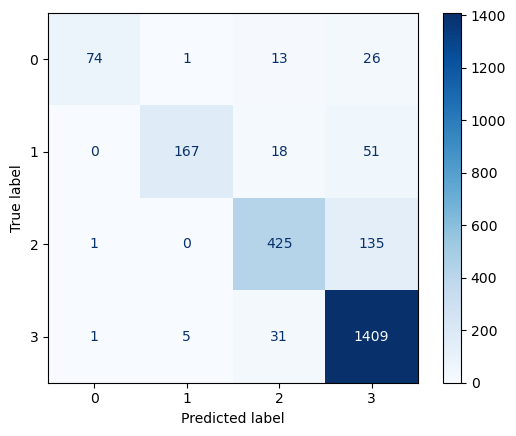

In [99]:
ConfusionMatrixDisplay.from_estimator(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [100]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

PARTICIPANTE_RENDA_PER_CAPITA              10.46
PARTICIPANTE_TP_COR_RACA                    3.53
PARTICIPANTE_TP_FAIXA_ETARIA                3.42
HABESTUDO_Q022                              3.17
HABESTUDO_Q021                              3.16
HABESTUDO_Q019                              3.04
HABESTUDO_Q005                              2.96
HABESTUDO_Q024                              2.90
HABESTUDO_Q013                              2.78
HABESTUDO_Q020                              2.76
HABESTUDO_Q009                              2.68
HABESTUDO_Q007                              2.68
HABESTUDO_Q012                              2.64
HABESTUDO_Q011                              2.62
HABESTUDO_Q010                              2.62
HABESTUDO_Q018                              2.59
HABESTUDO_Q016                              2.52
HABESTUDO_Q014                              2.51
HABESTUDO_Q015                              2.40
HABESTUDO_Q008                              2.39
HABESTUDO_Q023      

Regressor

In [101]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [102]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [103]:
randomforest_regressor_mae_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
randomforest_regressor_mae_scores.mean()

57.856701441397675

In [104]:
randomforest_regressor_rmse_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
randomforest_regressor_rmse_scores.mean()

72.63700813029483

In [105]:
randomforest_regressor_r2_scores = cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
randomforest_regressor_r2_scores.mean()

0.1851373922204123

In [106]:
randomforest_regressor_mape_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
randomforest_regressor_mape_scores.mean()

0.10311837227912055

In [107]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances

PARTICIPANTE_RENDA_PER_CAPITA              15.91
HABESTUDO_Q028H                             4.82
HABESTUDO_Q028G                             4.09
PARTICIPANTE_TP_FAIXA_ETARIA                3.58
HABESTUDO_Q019                              3.06
HABESTUDO_Q007                              3.06
HABESTUDO_Q024                              3.04
PARTICIPANTE_TP_COR_RACA                    3.02
HABESTUDO_Q011                              2.85
HABESTUDO_Q020                              2.85
HABESTUDO_Q022                              2.68
HABESTUDO_Q018                              2.61
HABESTUDO_Q005                              2.56
HABESTUDO_Q021                              2.46
HABESTUDO_Q006                              2.38
HABESTUDO_Q014                              2.33
HABESTUDO_Q013                              2.28
HABESTUDO_Q009                              2.22
HABESTUDO_Q028J                             2.04
HABESTUDO_Q023                              2.03
HABESTUDO_Q010      

In [108]:
# decelerating sklearn
unpatch_sklearn()

In [109]:
randomforest_feature_importances = pd.concat([pd.DataFrame(randomforest_classifier_feature_importances, columns=['classifier_importance']).reset_index(names='classifier_column'), pd.DataFrame(randomforest_regressor_feature_importances, columns=['regressor_importance']).reset_index(names='regressor_column')], axis=1).sort_values(['classifier_importance', 'regressor_importance'], ascending=False)
randomforest_feature_importances

,classifier_column,classifier_importance,regressor_column,regressor_importance
0,PARTICIPANTE_RENDA_PER_CAPITA,10.46,PARTICIPANTE_RENDA_PER_CAPITA,15.91
1,PARTICIPANTE_TP_COR_RACA,3.53,HABESTUDO_Q028H,4.82
2,PARTICIPANTE_TP_FAIXA_ETARIA,3.42,HABESTUDO_Q028G,4.09
3,HABESTUDO_Q022,3.17,PARTICIPANTE_TP_FAIXA_ETARIA,3.58
4,HABESTUDO_Q021,3.16,HABESTUDO_Q019,3.06
5,HABESTUDO_Q019,3.04,HABESTUDO_Q007,3.06
6,HABESTUDO_Q005,2.96,HABESTUDO_Q024,3.04
7,HABESTUDO_Q024,2.90,PARTICIPANTE_TP_COR_RACA,3.02
8,HABESTUDO_Q013,2.78,HABESTUDO_Q011,2.85
9,HABESTUDO_Q020,2.76,HABESTUDO_Q020,2.85


In [110]:
def get_hab_estudo_correspondent_column_names(df: pd.DataFrame, changing_columns: list) -> pd.DataFrame:
    '''
    Substitui as colunas de categoria dos hábitos de estudo pelo seu significado.

    :params:
    - df: DataFrame previamente tratado com todos os dados para substituição.
    - changing_columns: colunas com dados para serem alterados.

    Returns a DataFrame.
    '''

    hab_estudo_column_correspondent_names = {
        'HABESTUDO_Q005': 'Organizei cronograma de estudos com tempos mais longos e mais curtos para estudar de acordo com a dificuldade das matérias',
        'HABESTUDO_Q006': 'Reservei tempos mais longos e mais curtos para estudar de acordo com a dificuldade das matérias',
        'HABESTUDO_Q007': 'Organizei material para ser estudado',
        'HABESTUDO_Q008': 'Eu me dediquei aos horários programados de estudo de acordo com a dificuldade das matérias',
        'HABESTUDO_Q021': 'Entrei nas aulas online por videoconferência sem atraso da minha parte',
        'HABESTUDO_Q022': 'Assisti todas as aulas online nas datas programadas para estudo',
        'HABESTUDO_Q009': 'Li os textos indicados em cada matéria antes de assistir as aulas ou videoaulas sobre o assunto dos textos',
        'HABESTUDO_Q010': 'Resumi os textos das matérias, destacando as partes mais importantes',
        'HABESTUDO_Q011': 'Resumi as videoaulas ou os podcasts, destacando as partes mais importantes',
        'HABESTUDO_Q012': 'Fiz as atividades das matérias para fixação de conteúdo',
        'HABESTUDO_Q013': 'Fiz atividades avaliativas, inclusive simulados, para verificar o quanto aprendi durante a pandemia',
        'HABESTUDO_Q014': 'Aproveitei o tempo das aulas online ou atividades de reforço, sem desperdiçá-lo com distrações',
        'HABESTUDO_Q015': 'Anotei as explicações obtidas em videoaulas ou podcasts das matérias',
        'HABESTUDO_Q016': 'Anotei as informações que obtive ao assistir vídeos complementares de assuntos do meu interesse',
        'HABESTUDO_Q017': 'Destaquei as dúvidas que tive ao ler os textos das disciplinas para esclarecer com os professores',
        'HABESTUDO_Q018': 'Estruturei as principais ideias para produzir redações',
        'HABESTUDO_Q019': 'Treinei redação',
        'HABESTUDO_Q020': 'Participei de fóruns de discussão por matéria para tirar dúvidas',
        'HABESTUDO_Q023': 'Revisei as anotações das aulas, os resumos e anotações dos demais materiais que li ou assisti',
        'HABESTUDO_Q024': 'Reassisti as videoaulas e os podcasts das matérias',
        'HABESTUDO_Q027': 'Você vivenciou problemas em sua rotina para estudar ou manter-se informado(a) durante a pandemia?',
        'HABESTUDO_Q028A': 'Eu me senti desestimulado(a) por não ter colegas com quem interagir sobre o que eu estava estudando',
        'HABESTUDO_Q028B': 'Tive dificuldade de compreender os conteúdos por falta de explicações de um professor em tempo real',
        'HABESTUDO_Q028C': 'Fiquei por muito tempo diante das telas, sem pequenos intervalos para descansar',
        'HABESTUDO_Q028D': 'Reduzi a prática de atividades físicas',
        'HABESTUDO_Q028E': 'Dormi por menos tempo',
        'HABESTUDO_Q028F': 'Tive episódios de insônia',
        'HABESTUDO_Q028G': 'Senti dificuldade em manter a motivação para estudar por minha conta',
        'HABESTUDO_Q028H': 'Senti dificuldade em me motivar a cumprir meu cronograma',
        'HABESTUDO_Q028I': 'Senti medo de não conseguir aprender os conteúdos',
        'HABESTUDO_Q028J': 'Senti ansiedade devido ao isolamento social e ao receio de contágio da doença',
        'HABESTUDO_Q028K': 'Dediquei tempo para ajudar algum familiar a estudar em casa',
        'HABESTUDO_Q028L': 'Precisei ficar em repouso porque tive Covid com sintomas',
        'HABESTUDO_Q028M': 'Precisei ficar em repouso porque tive outra doença',
        'HABESTUDO_Q028N': 'Precisei cuidar de algum familiar que teve Covid com sintomas',
        'HABESTUDO_Q028O': 'Precisei cuidar de algum familiar que teve outra doença',
        'HABESTUDO_Q028P': 'Tive que cuidar do(s) meu(s) irmão(s) menor(es) para meus pais trabalharem',
        'HABESTUDO_Q028Q': 'Tive que começar a trabalhar em casa para obter renda',
        'HABESTUDO_Q028R': 'Tive que trabalhar em serviço considerado essencial durante a pandemia',
    }

    for column in changing_columns:
        df.loc[:, column] = df[column].replace(hab_estudo_column_correspondent_names)

    return df

In [111]:
randomforest_feature_importances = get_hab_estudo_correspondent_column_names(randomforest_feature_importances, ['classifier_column', 'regressor_column'])
randomforest_feature_importances

,classifier_column,classifier_importance,regressor_column,regressor_importance
0,PARTICIPANTE_RENDA_PER_CAPITA,10.46,PARTICIPANTE_RENDA_PER_CAPITA,15.91
1,PARTICIPANTE_TP_COR_RACA,3.53,Senti dificuldade em me motivar a cumprir meu ...,4.82
2,PARTICIPANTE_TP_FAIXA_ETARIA,3.42,Senti dificuldade em manter a motivação para e...,4.09
3,Assisti todas as aulas online nas datas progra...,3.17,PARTICIPANTE_TP_FAIXA_ETARIA,3.58
4,Entrei nas aulas online por videoconferência s...,3.16,Treinei redação,3.06
5,Treinei redação,3.04,Organizei material para ser estudado,3.06
6,Organizei cronograma de estudos com tempos mai...,2.96,Reassisti as videoaulas e os podcasts das maté...,3.04
7,Reassisti as videoaulas e os podcasts das maté...,2.90,PARTICIPANTE_TP_COR_RACA,3.02
8,"Fiz atividades avaliativas, inclusive simulado...",2.78,"Resumi as videoaulas ou os podcasts, destacand...",2.85
9,Participei de fóruns de discussão por matéria ...,2.76,Participei de fóruns de discussão por matéria ...,2.85


In [112]:
randomforest_feature_importances[['regressor_column', 'regressor_importance']]

,regressor_column,regressor_importance
0,PARTICIPANTE_RENDA_PER_CAPITA,15.91
1,Senti dificuldade em me motivar a cumprir meu ...,4.82
2,Senti dificuldade em manter a motivação para e...,4.09
3,PARTICIPANTE_TP_FAIXA_ETARIA,3.58
4,Treinei redação,3.06
5,Organizei material para ser estudado,3.06
6,Reassisti as videoaulas e os podcasts das maté...,3.04
7,PARTICIPANTE_TP_COR_RACA,3.02
8,"Resumi as videoaulas ou os podcasts, destacand...",2.85
9,Participei de fóruns de discussão por matéria ...,2.85


In [ ]:
complete_data_private.to_csv('../complete_private_df.csv', index=False)

In [ ]:
complete_data_private_creation_query = '''
CREATE TABLE projeto_enem.complete_data_private (
	"NU_INSCRICAO" BIGINT PRIMARY KEY,
	"PARTICIPANTE_TP_FAIXA_ETARIA" INTEGER,
	"PARTICIPANTE_TP_SEXO" VARCHAR(1),
	"PARTICIPANTE_TP_COR_RACA" INTEGER,
	"PARTICIPANTE_REGIAO_ESCOLA" VARCHAR(12),
	"NOTAS_NU_NOTA_MEDIA" FLOAT,
    "NOTAS_NU_NOTA_CONCEITO" INTEGER,
	"PARTICIPANTE_RENDA_PER_CAPITA" FLOAT,
	"HABESTUDO_Q005" VARCHAR(1),
	"HABESTUDO_Q006" VARCHAR(1),
	"HABESTUDO_Q007" VARCHAR(1),
	"HABESTUDO_Q008" VARCHAR(1),
	"HABESTUDO_Q021" VARCHAR(1),
	"HABESTUDO_Q022" VARCHAR(1),
	"HABESTUDO_Q009" VARCHAR(1),
	"HABESTUDO_Q010" VARCHAR(1),
	"HABESTUDO_Q011" VARCHAR(1),
	"HABESTUDO_Q012" VARCHAR(1),
	"HABESTUDO_Q013" VARCHAR(1),
	"HABESTUDO_Q014" VARCHAR(1),
	"HABESTUDO_Q015" VARCHAR(1),
	"HABESTUDO_Q016" VARCHAR(1),
	"HABESTUDO_Q017" VARCHAR(1),
	"HABESTUDO_Q018" VARCHAR(1),
	"HABESTUDO_Q019" VARCHAR(1),
	"HABESTUDO_Q020" VARCHAR(1),
	"HABESTUDO_Q023" VARCHAR(1),
	"HABESTUDO_Q024" VARCHAR(1),
	"HABESTUDO_Q027" VARCHAR(1),
	"HABESTUDO_Q028A" VARCHAR(1),
	"HABESTUDO_Q028B" VARCHAR(1),
	"HABESTUDO_Q028C" VARCHAR(1),
	"HABESTUDO_Q028D" VARCHAR(1),
	"HABESTUDO_Q028E" VARCHAR(1),
	"HABESTUDO_Q028F" VARCHAR(1),
	"HABESTUDO_Q028G" VARCHAR(1),
	"HABESTUDO_Q028H" VARCHAR(1),
	"HABESTUDO_Q028I" VARCHAR(1),
	"HABESTUDO_Q028J" VARCHAR(1),
	"HABESTUDO_Q028K" VARCHAR(1),
	"HABESTUDO_Q028L" VARCHAR(1),
	"HABESTUDO_Q028M" VARCHAR(1),
	"HABESTUDO_Q028N" VARCHAR(1),
	"HABESTUDO_Q028O" VARCHAR(1),
	"HABESTUDO_Q028P" VARCHAR(1),
	"HABESTUDO_Q028Q" VARCHAR(1),
	"HABESTUDO_Q028R" VARCHAR(1)
);
'''

complete_data_private_csv_query = '''
COPY projeto_enem.complete_data_private("NU_INSCRICAO", "PARTICIPANTE_TP_FAIXA_ETARIA", "PARTICIPANTE_TP_SEXO", "PARTICIPANTE_TP_COR_RACA", "PARTICIPANTE_REGIAO_ESCOLA", "NOTAS_NU_NOTA_MEDIA", "NOTAS_NU_NOTA_CONCEITO", "PARTICIPANTE_RENDA_PER_CAPITA", "HABESTUDO_Q005", "HABESTUDO_Q006", "HABESTUDO_Q007", "HABESTUDO_Q008", "HABESTUDO_Q021", "HABESTUDO_Q022", "HABESTUDO_Q009", "HABESTUDO_Q010", "HABESTUDO_Q011", "HABESTUDO_Q012", "HABESTUDO_Q013", "HABESTUDO_Q014", "HABESTUDO_Q015", "HABESTUDO_Q016", "HABESTUDO_Q017", "HABESTUDO_Q018", "HABESTUDO_Q019", "HABESTUDO_Q020", "HABESTUDO_Q023", "HABESTUDO_Q024", "HABESTUDO_Q027", "HABESTUDO_Q028A", "HABESTUDO_Q028B", "HABESTUDO_Q028C", "HABESTUDO_Q028D", "HABESTUDO_Q028E", "HABESTUDO_Q028F", "HABESTUDO_Q028G", "HABESTUDO_Q028H", "HABESTUDO_Q028I", "HABESTUDO_Q028J", "HABESTUDO_Q028K", "HABESTUDO_Q028L", "HABESTUDO_Q028M", "HABESTUDO_Q028N", "HABESTUDO_Q028O", "HABESTUDO_Q028P", "HABESTUDO_Q028Q", "HABESTUDO_Q028R")
FROM STDIN
WITH (DELIMITER ',',
ENCODING 'utf8',
FORMAT CSV,
HEADER);
'''


with db_connection() as conn, conn.cursor() as cursor:
    cursor.execute(complete_data_private_creation_query)
    conn.commit()
    
    with open('../complete_private_df.csv', encoding='utf8') as complete_data_private_csv_file:
        cursor.copy_expert(complete_data_private_csv_query, complete_data_private_csv_file)
        conn.commit()

In [ ]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.complete_private_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''

    cursor.execute(query)
    complete_data_private_fetched = cursor.fetchall()
    complete_data_private_columns = tuple(desc[0] for desc in cursor.description)


complete_data_private = pd.DataFrame(complete_data_private_fetched, columns=complete_data_private_columns)
complete_data_private